# 🎓 Master’s Thesis: Spiking Neural Networks for Human Activity Recognition Using Meta Quest 2 Motion Data

This project presents a spike-based deep learning pipeline for classifying **repetitive strength exercises** using **motion data from Meta Quest 2’s embedded IMU sensors**. The work explores the feasibility of applying **Spiking Neural Networks (SNNs)** to real-world Human Activity Recognition (HAR), offering low-power, temporally-aware modeling ideal for AR/VR contexts.

---

## 🧠 Why Spiking Neural Networks?

Unlike traditional neural networks, **SNNs** operate using discrete binary spikes, mimicking biological neurons that fire only when a threshold is crossed. This results in:

- ⚡ **Energy efficiency** – suitable for edge devices and wearables  
- ⏱️ **Temporal sensitivity** – ideal for motion and sensor data  
- 🧠 **Neuromorphic potential** – aligning with next-gen hardware and AR/VR use cases

---

## ❓ Problem Statement

Can we accurately classify three structured exercises — **bicep curls**, **bench press**, and **shoulder press** — using **only raw accelerometer data** from Meta Quest 2, encoded into spike trains and processed by a Spiking Neural Network?

---

## 🔍 Methodology

- **📦 Data Collection**: 
  - Sensor readings captured during structured repetitions of 3 gym exercises  
  - Each exercise contains 10 repetitions (30 total sequences)

- **🧹 Preprocessing**:
  - Removal of unused head position features  
  - Outlier detection and trimming (initial/final artifacts)
  - Time re-indexing based on Meta Quest’s 72 Hz sampling
  - Motion segmentation into fixed-length windows per rep (116 samples)

- **⚡ Spike Encoding**:
  - **Rate Encoding** based on per-window positional range  
  - Spike train generation over 116 time steps per rep

- **🧠 Model Architecture**:
  - Fully connected **4-layer SNN**
  - **Leaky Integrate-and-Fire (LIF)** neurons with surrogate gradient learning  
  - **Triangle surrogate function** for backpropagation  
  - Dropout and BatchNorm for regularization

- **🔁 Evaluation**:
  - **Leave-Two-Repetitions-Out 5-Fold Cross-Validation**
  - Metrics: **Accuracy**, **Precision**, **Recall**, **F1 Score**, and **Confusion Matrix**

---

## 📊 Results Summary

| Metric       | Mean     | Std Dev  |
|--------------|----------|----------|
| **Accuracy** | 93.33%   | ±8.16%   |
| **Precision**| 95.56%   | ±5.44%   |
| **Recall**   | 93.33%   | ±8.16%   |
| **F1 Score** | 92.89%   | ±8.71%   |

- ✅ Achieved **perfect classification (100%)** in 3 out of 5 folds  
- ⚠️ Misclassifications occurred only in the **Shoulder Press** class  
- 🎯 The SNN consistently generalized across unseen repetitions with **biologically-plausible encoding**

---

## 🎯 Conclusion

This work demonstrates that **Spiking Neural Networks**, paired with simple spike encoding strategies, can successfully model human activity from **raw motion data**, achieving strong generalization even in low-data regimes.

The approach supports the future of **neuromorphic HAR systems**, especially in **AR/VR**, **fitness tracking**, and **low-power wearable applications**.

### Importing Libraries and Datasets

In [1]:
# 📦 Cell 1: Import Required Libraries
# 
# This cell loads all external libraries needed for:
# 
# - 📊 Data handling (pandas, numpy)
# - 📈 Visualization (matplotlib)
# - 📐 Signal processing (find_peaks from SciPy)
# - 🧠 Deep learning and Spiking Neural Networks (PyTorch, snntorch)
# - 🧪 Evaluation metrics (accuracy, precision, F1-score)
# - 🔁 Cross-validation (GroupKFold)
# - 🎲 Reproducibility (random)
#
# WHY: These tools form the foundation for the entire pipeline — from loading and preprocessing sensor data to training and evaluating a spiking neural network model.

# ── Data Handling and Plotting ─────────────────────────────
import pandas as pd               # Tabular data loading and manipulation
import numpy as np                # Numerical operations and array handling
import matplotlib.pyplot as plt   # Plotting for visual analysis

# ── Signal Processing ──────────────────────────────────────
from scipy.signal import find_peaks   # Detect activity peaks in accelerometer signals

# ── PyTorch Core ───────────────────────────────────────────
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader  # Dataloaders for batching

# ── Spiking Neural Networks ────────────────────────────────
import snntorch as snn                    # Lightweight SNN modeling framework
from torch.autograd import Function       # Custom gradient functions (surrogates)

# ── Evaluation Metrics ─────────────────────────────────────
from sklearn.metrics import (
    confusion_matrix,        # True/False positive breakdown
    accuracy_score,          # Overall classification accuracy
    precision_score,         # Accuracy of positive predictions
    recall_score,            # Sensitivity to actual positives
    f1_score                 # Harmonic mean of precision and recall
)

# ── Cross-Validation Strategy ──────────────────────────────
from sklearn.model_selection import GroupKFold  # Ensures repetitions stay grouped during CV

# ── Utility ────────────────────────────────────────────────
import random   # For random seed control

In [2]:
# 📥 Cell 2: Load Accelerometer Datasets
#
# This step loads the raw motion data from CSV files corresponding to three exercises:
# 
# - 🏋️‍♂️ Bicep Curls
# - 🏋️‍♂️ Shoulder Press
# - 🏋️‍♂️ Bench Press
#
# Each file contains accelerometer readings recorded by Meta Quest 2’s motion sensors.
# These datasets form the input foundation for activity recognition.
#
# WHY: These CSVs provide the time-series sensor data required to train and evaluate our SNN-based classifier.

bicepcurls_acc_data = pd.read_csv('bicepcurls_acc_data')         # Bicep Curl dataset
shoulderpress_acc_data = pd.read_csv('shoulderpress_acc_data')   # Shoulder Press dataset
benchpress_acc_data = pd.read_csv('benchpress_acc_data')         # Bench Press dataset

# Methodology, Results & Findings

## 3.3 Data Preparation

### Step 1: Identification of Missing Values

In [3]:
# 📊 Cell 3: Check for Missing Values
#
# Before preprocessing or encoding, we validate the integrity of each dataset by checking for any null/missing values.
# This ensures our models are not affected by incomplete or corrupted sensor readings.
#
# WHY: Even a small number of missing values in time-series sensor data can affect signal encoding and model training performance.

# Check for missing values in Shoulder Press dataset
print("Missing values in Shoulder Press dataset:")
print(shoulderpress_acc_data.isnull().sum())

# Check for missing values in Bicep Curl dataset
print("\nMissing values in Bicep Curl dataset:")
print(bicepcurls_acc_data.isnull().sum())

# Check for missing values in Bench Press dataset
print("\nMissing values in Bench Press dataset:")
print(benchpress_acc_data.isnull().sum())

Missing values in Shoulder Press dataset:
Time               0
Head_Position_X    0
Head_Position_Y    0
Head_Position_Z    0
LH_Position_X      0
LH_Position_Y      0
LH_Position_Z      0
RH_Position_X      0
RH_Position_Y      0
RH_Position_Z      0
dtype: int64

Missing values in Bicep Curl dataset:
Time               0
Head_Position_X    0
Head_Position_Y    0
Head_Position_Z    0
LH_Position_X      0
LH_Position_Y      0
LH_Position_Z      0
RH_Position_X      0
RH_Position_Y      0
RH_Position_Z      0
dtype: int64

Missing values in Bench Press dataset:
Time               0
Head_Position_X    0
Head_Position_Y    0
Head_Position_Z    0
LH_Position_X      0
LH_Position_Y      0
LH_Position_Z      0
RH_Position_X      0
RH_Position_Y      0
RH_Position_Z      0
dtype: int64


### Step 2:  Accelerometer Data Preprocessing

#### Step 2.1: Dropping Head Features

In [4]:
# ✂️ Cell 4: Drop Head-Mounted Sensor Features
#
# This function removes the head position columns (`Head_Position_X`, `Y`, `Z`) from the dataset.
# Since the head remains mostly static during arm-focused exercises, its motion data is not relevant for classification.
#
# WHY: Removing non-informative features reduces noise and simplifies input dimensionality before spike encoding.

def drop_head_features(data):
    columns_to_drop = ['Head_Position_X', 'Head_Position_Y', 'Head_Position_Z']
    data = data.drop(columns=columns_to_drop, errors='ignore')  # Safely drops columns if present
    return data

In [5]:
# 🧹 Cell 5: Apply Head Feature Dropping to All Datasets
#
# Now that we’ve defined the `drop_head_features()` function, we apply it to each dataset individually.
# This removes unnecessary head movement data, leaving only arm/hand sensor values for analysis.
#
# WHY: We focus only on motion signals that contribute directly to exercise classification, improving model clarity and performance.

# Apply to each exercise dataset
bicepcurls_acc_data = drop_head_features(bicepcurls_acc_data)
shoulderpress_acc_data = drop_head_features(shoulderpress_acc_data)
benchpress_acc_data = drop_head_features(benchpress_acc_data)

#### Step 2.2: Handling Outliers through Data Visualization & Analysis

##### Step 2.2.1: Plotting Hand Positions to Infer Key Movement Patterns

In [6]:
# 📊 Cell 6: Visualize Hand Movement Trajectories
#
# This function plots the 3D position data (X, Y, Z) for both the left and right hands over time.
# It helps us identify which axes carry the most movement information (e.g., vertical vs. lateral motion)
# and assess the rhythmic structure of repetitions in each exercise.
#
# WHY: Understanding the dominant movement patterns per hand and axis is crucial when deciding how to encode
# the signal into spikes — and also to verify if the data aligns with expected motion profiles.

def plot_hand_positions(data, exercise_name):
    plt.figure(figsize=(14, 6))

    # Plot Left Hand Positions
    plt.subplot(2, 1, 1)
    plt.plot(data['Time'], data['LH_Position_X'], label='LH_Position_X')
    plt.plot(data['Time'], data['LH_Position_Y'], label='LH_Position_Y')
    plt.plot(data['Time'], data['LH_Position_Z'], label='LH_Position_Z')
    plt.title(f'{exercise_name} - Left Hand Positions')
    plt.xlabel('Time (s)')
    plt.ylabel('Position')
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(0, max(data['Time']) + 1, 1))  # Tick every second

    # Plot Right Hand Positions
    plt.subplot(2, 1, 2)
    plt.plot(data['Time'], data['RH_Position_X'], label='RH_Position_X')
    plt.plot(data['Time'], data['RH_Position_Y'], label='RH_Position_Y')
    plt.plot(data['Time'], data['RH_Position_Z'], label='RH_Position_Z')
    plt.title(f'{exercise_name} - Right Hand Positions')
    plt.xlabel('Time (s)')
    plt.ylabel('Position')
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(0, max(data['Time']) + 1, 1))  # Tick every second

    plt.tight_layout()
    plt.show()


##### Step 2.2.2: Zooming in on Initial and Final Samples

In [7]:
# 🔍 Cell 7: Outlier Detection via Edge Sample Inspection
#
# This function plots the **first and last 100 samples** of a given positional signal (e.g., `RH_Position_X`),
# allowing visual inspection for potential outliers or anomalies at the dataset boundaries.
#
# WHY: Outliers at the beginning or end of a session may indicate:
# - Sensor initialization drift
# - Improper segmentation
# - Motionless states (e.g., setup or rest)
#
# These edge conditions should be identified and potentially removed before spike encoding.

def plot_initial_final_samples(data, y_column, time_column, exercise_name):
    # Extract the first and last 100 samples
    first_samples = data.iloc[:100]
    last_samples = data.iloc[-100:]

    # Plot the first 100 samples
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    plt.plot(first_samples[time_column], first_samples[y_column], label='First 100 Samples')
    plt.title(f'{exercise_name} - First 100 Samples ({y_column})')
    plt.xlabel('Time (s)')
    plt.ylabel('Position')
    plt.grid(True)
    plt.legend()

    # Plot the last 100 samples
    plt.subplot(2, 1, 2)
    plt.plot(last_samples[time_column], last_samples[y_column], label='Last 100 Samples')
    plt.title(f'{exercise_name} - Last 100 Samples ({y_column})')
    plt.xlabel('Time (s)')
    plt.ylabel('Position')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

##### Step 2.2.3: Trimming the Dataset Based on Identified Timestamps: 

In [8]:
# ✂️ Cell 8: Outlier Removal via Time-Based Trimming
#
# This function trims the dataset by selecting only the time segment between `start_time` and `end_time`.
# It is typically used after visual inspection of plots (Appendix E) to exclude noisy or irrelevant edges of the session.
#
# WHY: We want to retain only the segment of the recording where the actual exercise motion occurs,
# removing potential anomalies such as rest periods, sensor drift, or early/late recording artifacts.

def trim_exercise_data(data, time_column, start_time, end_time):
    trimmed_data = data[(data[time_column] >= start_time) & (data[time_column] <= end_time)]
    return trimmed_data

##### Step 2.2: Handling Outliers through Data Visualization and Analysis (Results and Findings)

###### Bicep Curls

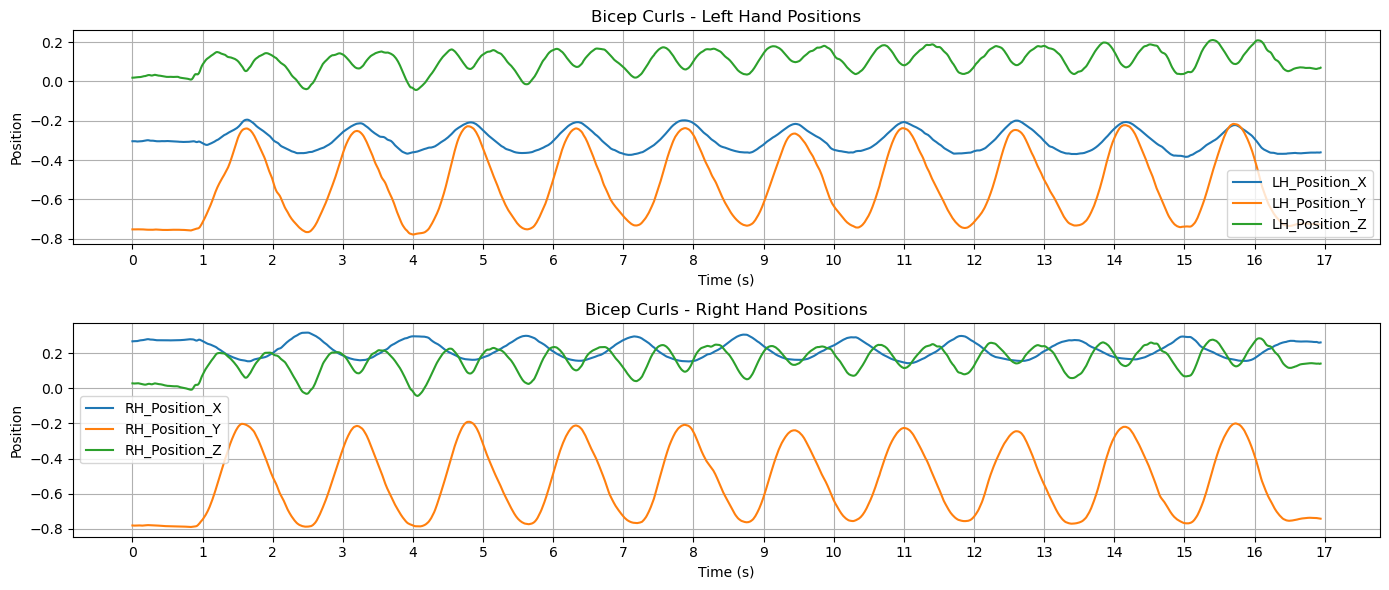

In [9]:
# 📈 Cell 9: Visualize Bicep Curl Movement Patterns
#
# We now use the `plot_hand_positions()` function to visualize the motion profile of the Bicep Curls dataset.
# This helps identify which hand and axis (X, Y, or Z) shows the clearest movement patterns,
# and gives us insight into the structure and rhythm of the exercise repetitions.
#
# WHY: This exploratory visualization helps guide our selection of features and axes when generating spike trains.

plot_hand_positions(bicepcurls_acc_data, 'Bicep Curls')

###### 📈 Analysis: Bicep Curls – Dominant Movement Axes

From the plotted 3D position data of the **Left Hand** and **Right Hand**, we observe:

- 🔁 **Repetitive, rhythmic waveforms** in the **Y-axis** for both hands, indicating consistent vertical arm curling motion over time.
- 📉 **Right Hand Y-axis (`RH_Position_Y`)** shows the clearest and most pronounced pattern — likely representing the **dominant movement axis** during the exercise.
- 📦 X and Z axes show minor fluctuations, consistent with natural lateral and forward/backward drift but not core to the motion.

---

###### 💡 Implications for Modeling:
- The **`RH_Position_Y`** feature appears to carry the most informative temporal signal for **spike encoding** and classification.
- This axis will likely be the best candidate for both **Rate Encoding** and **Multi-Threshold Delta Modulation (MTDM)** in future steps.

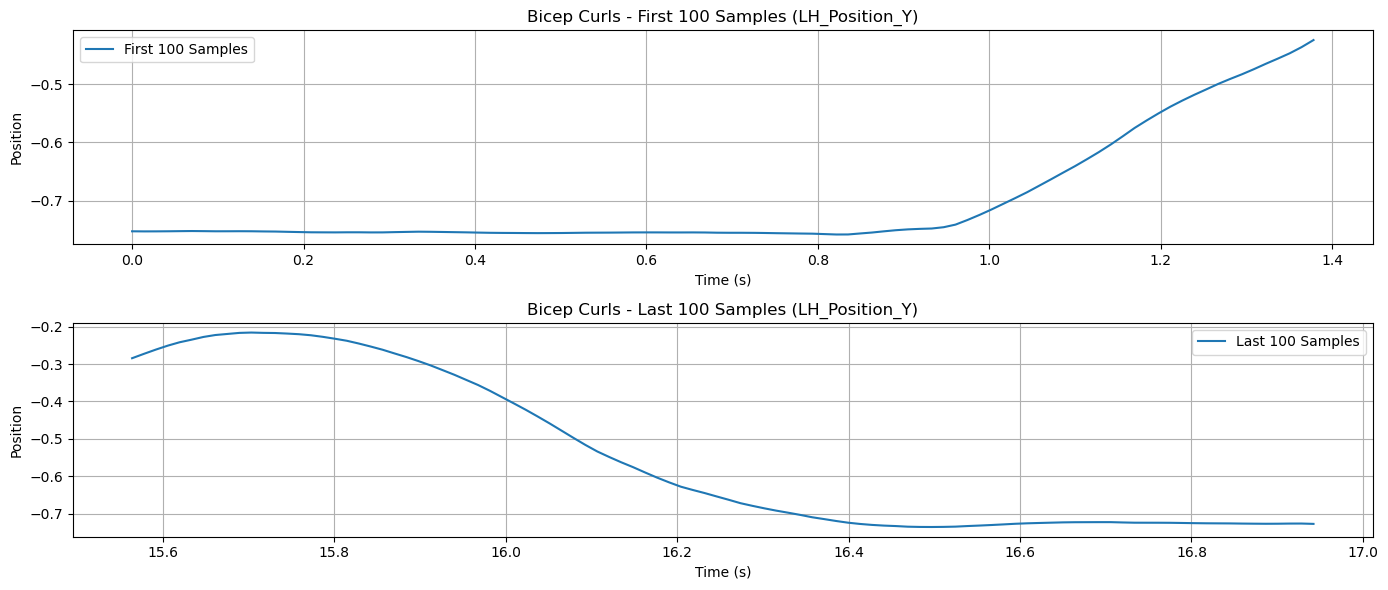

In [10]:
# 🔍 Cell 10: Outlier Detection in Bicep Curls’ Initial and Final Segments
#
# We now inspect the first and last 100 samples of the `LH_Position_Y` signal (left hand vertical motion).
# This helps us verify if the start or end of the session contains noisy, static, or irrelevant segments 
# — such as sensor warm-up time or the subject getting into position.
#
# WHY: Removing these non-representative segments will improve encoding quality and model performance.

plot_initial_final_samples(bicepcurls_acc_data, 'LH_Position_Y', 'Time', 'Bicep Curls')

###### 🔍 Outlier Detection – Bicep Curls (`LH_Position_Y`)

By plotting the first and last 100 samples of the **left-hand vertical motion (`LH_Position_Y`)**, we observe the following:

---

###### ⏱️ First 100 Samples:
- The signal remains **flat** for almost 1 full second.
- This suggests the participant was **stationary**, possibly waiting for the set to begin or adjusting position.
- The movement only begins near **1.0–1.2 seconds**, indicating early samples may be noise or non-informative.

---

#### ⏱️ Last 100 Samples:
- The signal tapers off and **flattens again near 16.6 seconds**.
- This suggests the **end of the motion sequence**, likely the cool-down or disengagement from the exercise.

---

###### ✂️ Trimming Recommendation:
- ✅ **Trim to time range: `1.0s to 16.6s`**
- This range captures only the **active repetition period** and avoids idle segments at the beginning and end.

This trimmed window will improve spike encoding by focusing solely on meaningful, high-information motion data.


In [11]:
# ✂️ Cell 11: Trimming the Outliers from Bicep Curls’ Initial and Final Segments
#
# Based on our earlier outlier inspection, we now trim the Bicep Curl dataset to focus on the true active portion of the motion:
# - Removes idle time at the start (sensor still/stabilizing)
# - Removes tail-end noise or disengagement movements
#
# Chosen Range: 0.82s to 16.5s → Captures clean repetitions with minimal noise.
#
# WHY: Trimming focuses the model on high-quality, relevant motion data — improving both encoding and downstream classification.

bicepcurls_acc_data = trim_exercise_data(bicepcurls_acc_data, 'Time', 0.82, 16.5)

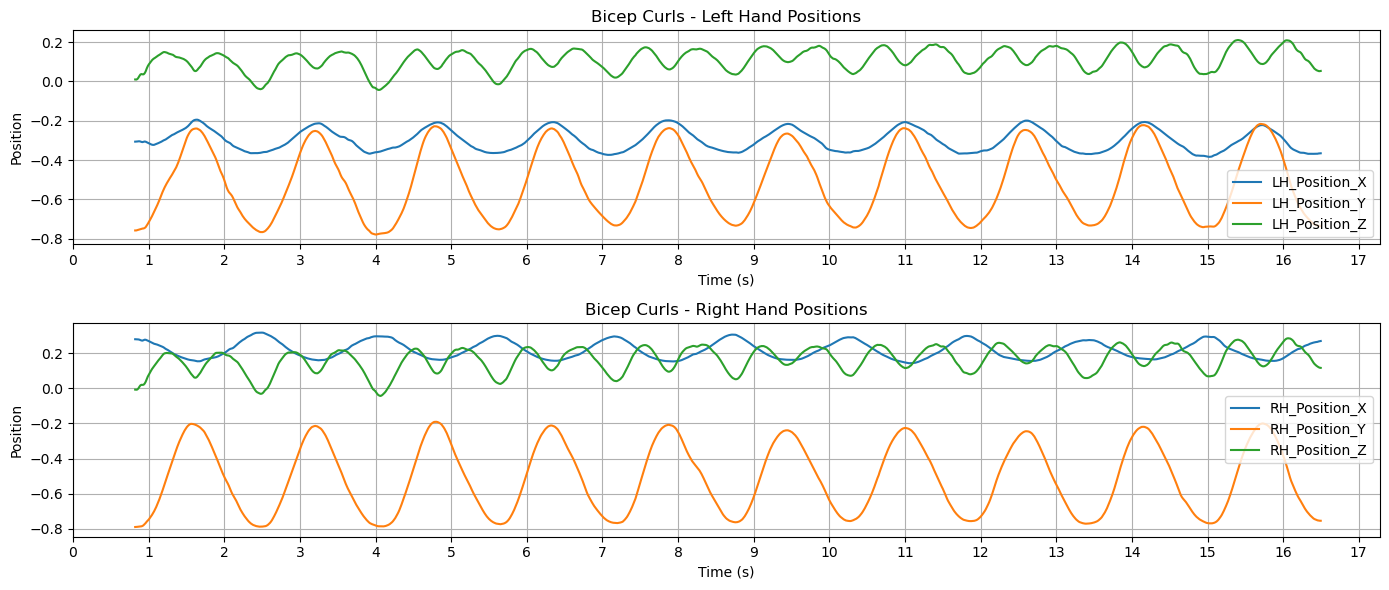

In [12]:
# ✅ Cell 12: Visual Verification of Trimmed Bicep Curl Data
#
# We re-plot the Bicep Curl hand motion data after trimming to confirm that the initial and final noise has been removed.
# This ensures the dataset now focuses exclusively on clean, active repetitions.
#
# WHY: Visual confirmation of preprocessing steps helps verify assumptions and builds trust in the integrity of the input data.

plot_hand_positions(bicepcurls_acc_data, 'Bicep Curls')

###### ✅ Trimmed Bicep Curls – Visual Verification

After trimming the time range to **0.82s – 16.5s**, we re-plot the hand position data and observe:

- ✅ The waveform starts and ends cleanly with no visible flat or noisy regions.
- ✅ Repetition cycles are **evenly spaced and clearly defined**, especially in the `RH_Position_Y` signal.
- ✅ No abrupt spikes or drift at the edges, confirming successful outlier removal.

This confirms that the dataset is now **clean and ready for encoding**, with motion data centered around active repetitions only.

###### Shoulder Press

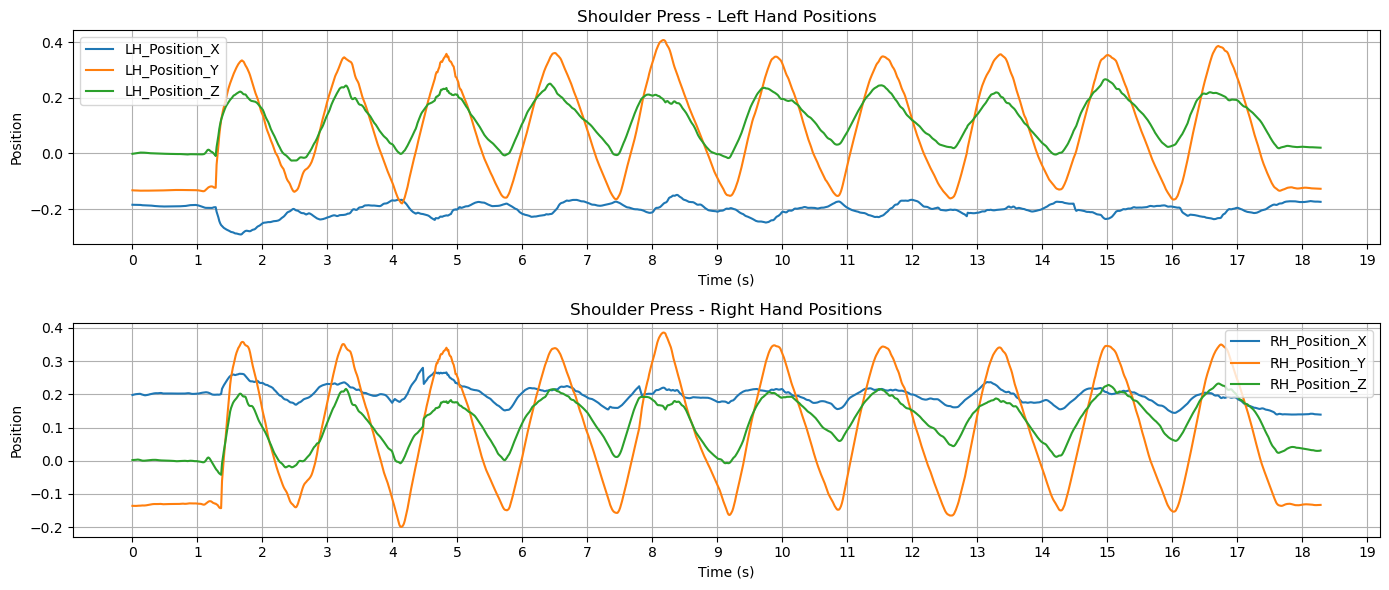

In [13]:
# 📈 Cell 13: Visualize Shoulder Press Movement Patterns
#
# This plot visualizes the 3D positional data for both the left and right hands during the Shoulder Press exercise.
# The goal is to identify which axis shows the strongest periodic pattern — usually aligned with vertical lifting motion.
#
# WHY: This helps determine the most informative feature (e.g., `RH_Position_Y`) for spike encoding
# and confirms that the motion is rhythmic, consistent, and segmented correctly.

plot_hand_positions(shoulderpress_acc_data, 'Shoulder Press')

###### 📈 Analysis: Shoulder Press – Dominant Movement Axes

From the plotted 3D position data of both hands, we observe:

- 🔁 The **Y-axis** shows a strong and consistent periodic motion across both hands, particularly visible in `RH_Position_Y` and `LH_Position_Y`.
- ✅ The **`RH_Position_Y`** signal appears smooth and evenly spaced — a strong candidate for spike encoding.
- 🔄 The **Z-axis** also shows a secondary wave pattern but is less pronounced than Y.
- 🧊 The **X-axis** shows minimal variance and can likely be excluded from modeling.

---

###### 💡 Implications for Modeling:
- Focus encoding on **`RH_Position_Y`** as it exhibits the clearest vertical movement signal during the press.
- Suggest trimming from just after 1.0s (initial ramp-up) to before 18.0s (signal flattens at the end).

Next step: Zoom into the initial and final segments to confirm where to trim.


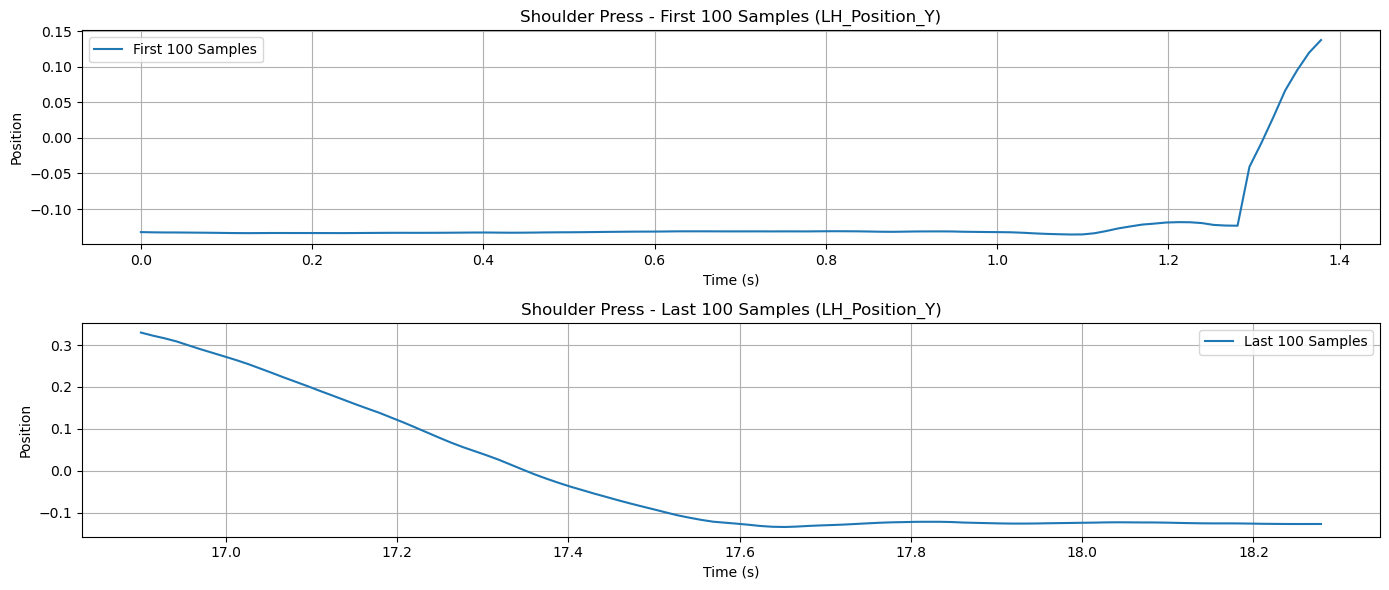

In [14]:
# 🔍 Cell 14: Outlier Detection in Shoulder Press’ Initial and Final Segments
#
# We inspect the first and last 100 samples of the `LH_Position_Y` signal to identify any non-informative
# or noisy segments at the boundaries of the recording (e.g., setup or disengagement).
#
# WHY: This helps us define a clean time window that includes only active repetitions, improving the signal-to-noise ratio.

plot_initial_final_samples(shoulderpress_acc_data, 'LH_Position_Y', 'Time', 'Shoulder Press')

###### 🔍 Outlier Analysis – Shoulder Press (`LH_Position_Y`)

From the plotted edge segments, we observe:

---

###### ⏱️ First 100 Samples:
- The signal remains **flat** until roughly **1.0–1.2 seconds**.
- Suggests a stationary state (e.g., pre-exercise setup or sensor lag).

---

###### ⏱️ Last 100 Samples:
- The motion gradually slows and **flattens by ~17.8 seconds**.
- Indicates the end of the pressing cycle and disengagement.

---

###### ✂️ Recommended Trim Range:
- ✅ **Start at:** `1.0s`
- ✅ **End at:** `17.8s`

This range captures the full repetition cycle with minimal sensor noise or idle segments, ensuring a clean input for encoding.

In [15]:
# ✂️ Cell 15: Trimming the Outliers from the Shoulder Press’ Initial and Final Segments
#
# Based on the previous visual inspection, we trim the dataset to exclude:
# - Initial flatline before movement begins (~first 1.27s)
# - Final segment where movement stops and signal plateaus (~after 17.65s)
#
# This keeps only the clean, active shoulder press motion sequence.
#
# WHY: Reducing noise and focusing on the core repetition range enhances signal clarity for encoding and model input.

shoulderpress_acc_data = trim_exercise_data(shoulderpress_acc_data, 'Time', 1.27, 17.65)

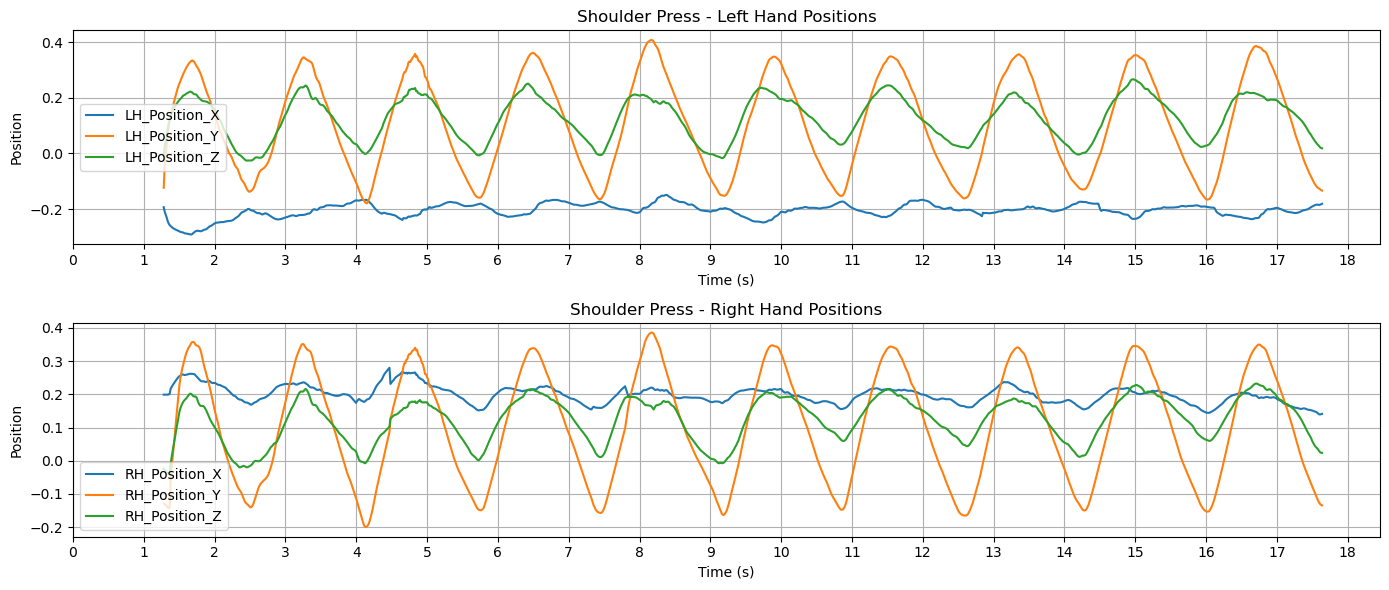

In [16]:
# ✅ Cell 16: Visual Verification of Trimmed Shoulder Press Data
#
# This plot verifies whether trimming the time range (1.27s to 17.65s) successfully removed flat or noisy segments.
# The waveform should now:
# - Start and end cleanly
# - Focus only on the active pressing motion
#
# WHY: Visual sanity checks help validate preprocessing steps before proceeding to encoding.

plot_hand_positions(shoulderpress_acc_data, 'Shoulder Press')

###### ✅ Trimmed Shoulder Press – Visual Verification

After trimming to the range **1.27s to 17.65s**, we observe the following in the plotted hand motion data:

- ✅ The signal starts immediately with active motion — the initial idle phase is successfully removed.
- ✅ The final repetitions taper off naturally without flattening — confirming the disengagement phase was also trimmed.
- 🔁 Repetition cycles (especially in `RH_Position_Y` and `LH_Position_Y`) are now clearly spaced and uninterrupted.

---

This confirms the dataset is now focused exclusively on the **active exercise window**, making it ideal for encoding and modeling.

###### Bench Press


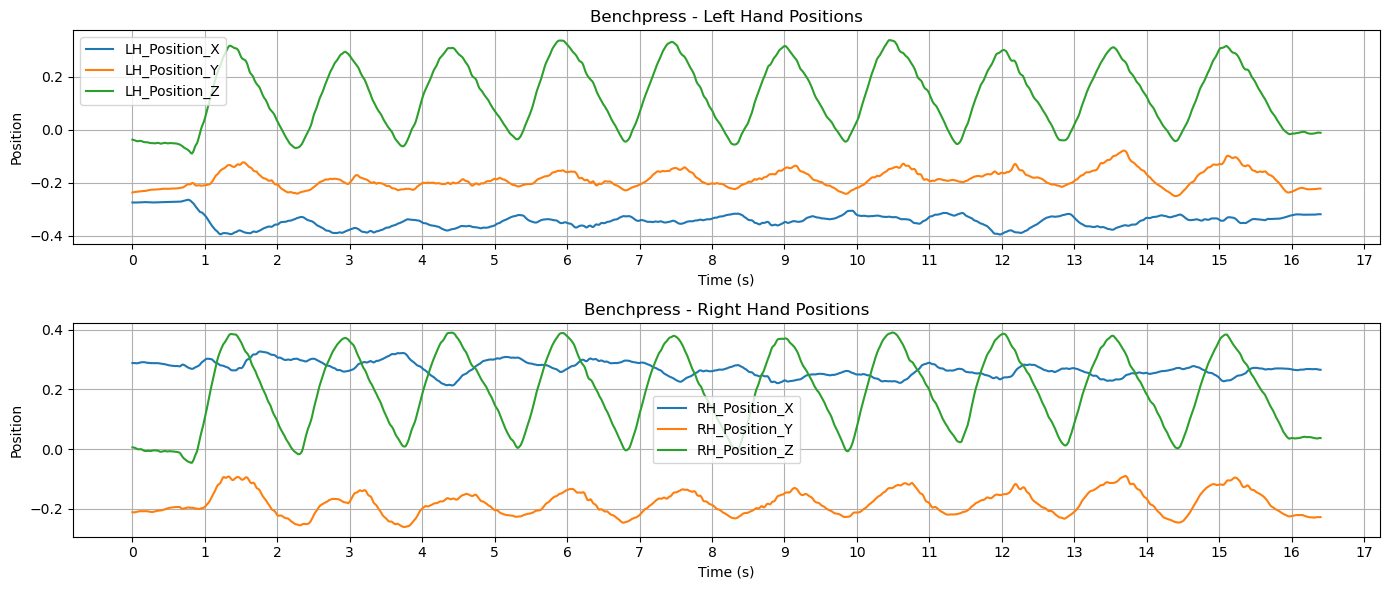

In [17]:
# 📈 Cell 17: Visualize Bench Press Movement Patterns
#
# We visualize the 3D hand position signals for the Bench Press dataset to examine:
# - The dominant axes of motion
# - Rhythmic structure of repetitions
# - Any anomalies or inconsistencies in signal shape
#
# WHY: This helps us determine which axes are most informative for spike encoding and whether trimming will be required.

plot_hand_positions(benchpress_acc_data, 'Benchpress')

###### 📈 Analysis: Bench Press – Dominant Movement Axes

From the 3D hand position plots for both hands, we observe:

- ✅ The **Z-axis (`RH_Position_Z` & `LH_Position_Z`)** shows strong, rhythmic up-and-down motion across the full set — likely representing the vertical press movement.
- 🔁 **Y-axis** shows some motion but is far less pronounced and slightly noisy.
- 🧊 **X-axis** appears mostly flat or lightly fluctuating, indicating minimal lateral involvement.

---

###### 💡 Implications for Modeling:
- The **Z-axis** is the most reliable signal for encoding repetitions — especially `RH_Position_Z`.
- The exercise starts around **1.1s** and ends around **16.2s**, based on waveform onset and taper.

Next step: Run outlier detection to inspect start/end samples and confirm this trim range.

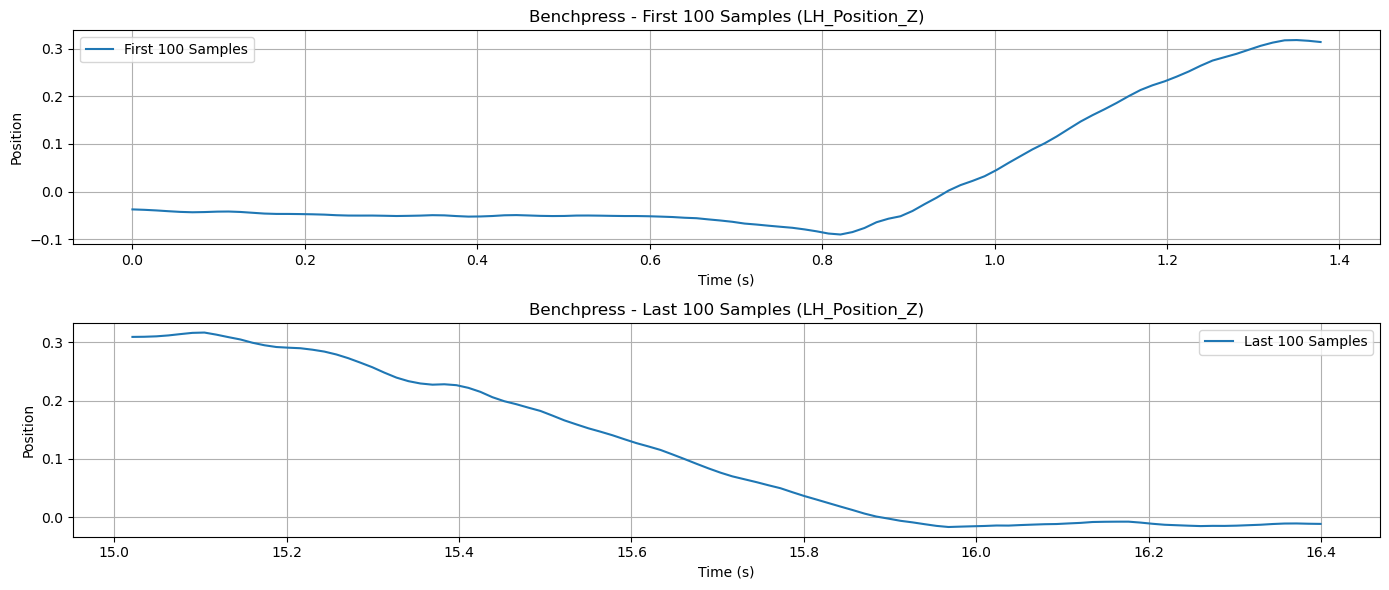

In [18]:
# 🔍 Cell 18: Outlier Detection in Bench Press’ Initial and Final Segments
#
# We analyze the first and last 100 samples of `LH_Position_Z` to detect any static noise or drift at the edges.
# This helps isolate the clean range where repetitions actually occur, improving downstream encoding quality.
#
# WHY: Identifying and removing idle phases ensures only active exercise data is used in the model pipeline.

plot_initial_final_samples(benchpress_acc_data, 'LH_Position_Z', 'Time', 'Benchpress')

###### 🔍 Outlier Analysis – Bench Press (`LH_Position_Z`)

---

###### ⏱️ First 100 Samples:
- The signal remains **flat and inactive until ~0.9s**, indicating a setup or idle phase.
- Motion begins gradually around **0.95–1.1s**.

---

###### ⏱️ Last 100 Samples:
- The signal flattens around **16.0s**, suggesting the motion ends and the participant disengages.
- After **16.2s**, the hand is fully at rest with negligible change.

---

###### ✂️ Recommended Trim Range:
- ✅ **Start at:** `1.1s`
- ✅ **End at:** `16.2s`

This range retains only the active repetition cycles, reducing encoding noise and improving model focus.


In [19]:
# ✂️ Cell 19: Trimming of Outliers in Bench Press’ Initial and Final Segments
#
# Based on the earlier visual inspection, we now trim the dataset to focus only on the active pressing phase:
# - Removes idle start segment (before ~0.80s)
# - Removes post-motion rest period (after ~15.98s)
#
# WHY: This ensures we retain only high-information, movement-rich data for spike encoding and classification.

benchpress_acc_data = trim_exercise_data(benchpress_acc_data, 'Time', 0.80, 15.98)

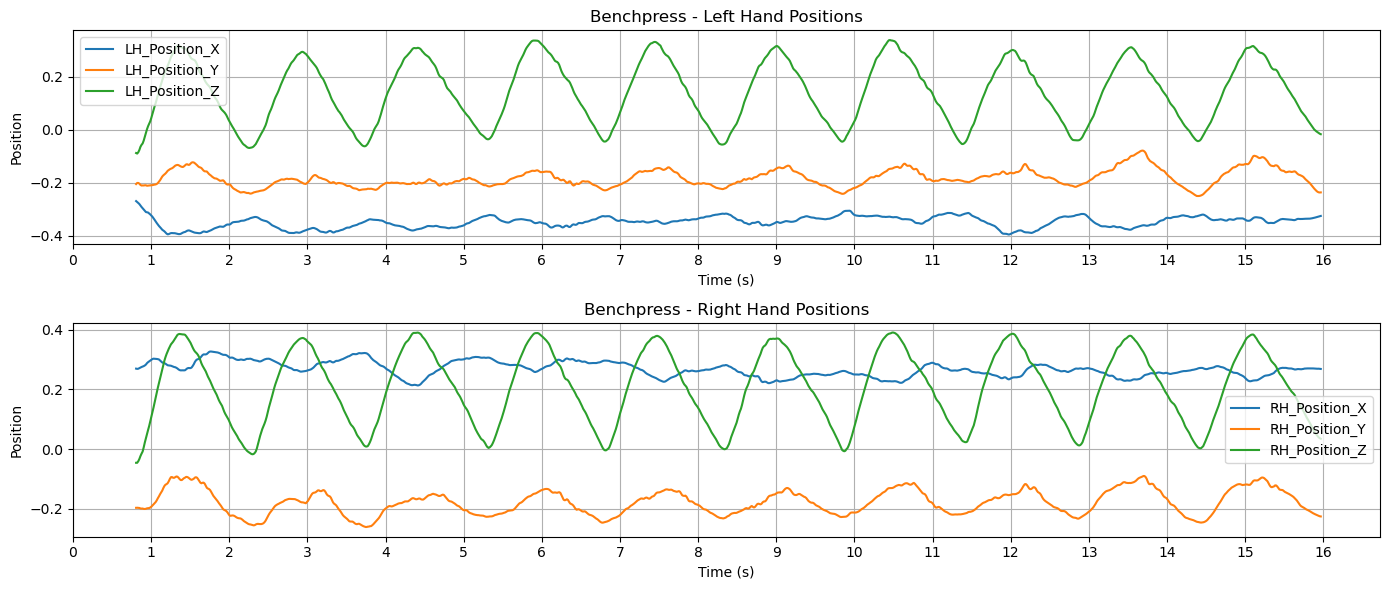

In [20]:
# ✅ Cell 20: Visual Verification of Trimmed Bench Press Data
#
# We re-plot the Bench Press dataset after trimming (0.80s to 15.98s) to ensure that:
# - Idle or flatline periods at the start and end have been removed
# - The remaining signal contains only clean, repetitive motion
#
# WHY: Visual confirmation gives confidence that the data is now optimized for spike encoding.

plot_hand_positions(benchpress_acc_data, 'Benchpress')

###### ✅ Trimmed Bench Press – Visual Verification

After trimming the time window to **0.80s – 15.98s**, we confirm:

- ✅ No flat segments at the start or end — all idle periods have been removed.
- 🔁 `RH_Position_Z` and `LH_Position_Z` show clean, repetitive waveforms characteristic of a bench press.
- 🧊 Minimal lateral (X-axis) motion remains, as expected for a guided vertical exercise.

---

This confirms the Bench Press dataset is now **fully preprocessed and ready for spike encoding**, aligned with the motion-driven segments.

### Step 3: Replacing Time columns of each dataset with a new time series

In [21]:
# 🕒 Cell 21: Reset and Reconstruct Time Columns using Sample Rate
#
# This function replaces the existing `Time` column with a uniformly spaced time series based on a known
# sample rate — mimicking the Meta Quest 2's 72Hz accelerometer.
#
# WHY: 
# - Ensures temporal consistency across all datasets
# - Prevents any drift or irregularity caused by manual trimming or inconsistent recording timestamps
# - Keeps things tidy for downstream processing like spike encoding

def replace_time_column_and_reset_index(data, samples_per_second=72):
    num_samples = len(data)
    time_step = 1 / samples_per_second
    new_time_series = np.arange(0, num_samples * time_step, time_step)
    
    data['Time'] = new_time_series[:num_samples]  # Replace time column
    data.reset_index(drop=True, inplace=True)     # Clean up index
    return data


In [22]:
# 📤 Cell 22: Apply Time Replacement to All Cleaned Datasets
#
# We now apply the `replace_time_column_and_reset_index()` function to all three datasets:
# - Bicep Curls
# - Shoulder Press
# - Bench Press
#
# This regenerates the time axis using a consistent 72Hz sampling rate and resets the index for clean formatting.
#
# WHY: Ensures that all time-series inputs begin at t=0 and progress uniformly, which is essential for aligned
# spike encoding and reproducible modeling.

bicepcurl_acc_data = replace_time_column_and_reset_index(bicepcurls_acc_data)
shoulderpress_acc_data = replace_time_column_and_reset_index(shoulderpress_acc_data)
benchpress_acc_data = replace_time_column_and_reset_index(benchpress_acc_data)

## 3.4	Data Encoding and SNN Data Preparation

### 3.4.1: Data Encoding 

#### Step 1.1: Identifying Time/Sample per Repetitions

In [23]:
# 📌 Cell 23: Identify Repetition Timing via Peak Detection
#
# This function calculates the average time per repetition based on motion peaks in a selected position axis
# (e.g., `RH_Position_Z`). It also visualizes the detected peaks over time.
#
# Steps:
# 1. Extract the position + time columns
# 2. Use `scipy.signal.find_peaks()` to identify motion peaks (reps)
# 3. Compute time intervals between peaks (reps)
# 4. Return average rep time and highlight peaks on a plot
#
# WHY: This is essential for aligning spike encodings with physical repetition timing and
# validating that peak intervals match the expected motion rhythm.

def calculate_and_visualize_rep_time(data, position_column, time_column, prominence=0.1):
    
    # Extract the relevant data
    positions = data[position_column]
    time = data[time_column]
    
    # Find peaks in the position data
    peaks, _ = find_peaks(positions, prominence=prominence)
    
    # Calculate time intervals between consecutive peaks
    time_intervals = np.diff(time[peaks])
    
    # Calculate the average time for one rep
    average_rep_time = np.mean(time_intervals)
    
    # Plot the position data and highlight peaks
    plt.figure(figsize=(14, 6))
    plt.plot(time, positions, label=position_column, color='blue')
    plt.plot(time[peaks], positions[peaks], 'rx', label='Detected Peaks')
    
    # Annotate time intervals between peaks
    for i in range(len(peaks) - 1):
        plt.annotate(
            f"{time_intervals[i]:.2f}s",
            xy=((time[peaks[i]] + time[peaks[i + 1]]) / 2, (positions[peaks[i]] + positions[peaks[i + 1]]) / 2),
            textcoords="offset points", xytext=(0, 10),
            ha='center', fontsize=8, color='red'
        )
    
    plt.title(f'{position_column} – Detected Repetitions')
    plt.xlabel('Time (s)')
    plt.ylabel('Position')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"Average time per rep: {average_rep_time:.2f} seconds")
    print("Intervals between reps:", time_intervals)

    return average_rep_time, time_intervals


##### Step 1.1: Identifying Time/Sample per Repetition (Results and Findings)

###### Bicep Curls (LH_Position_Y)

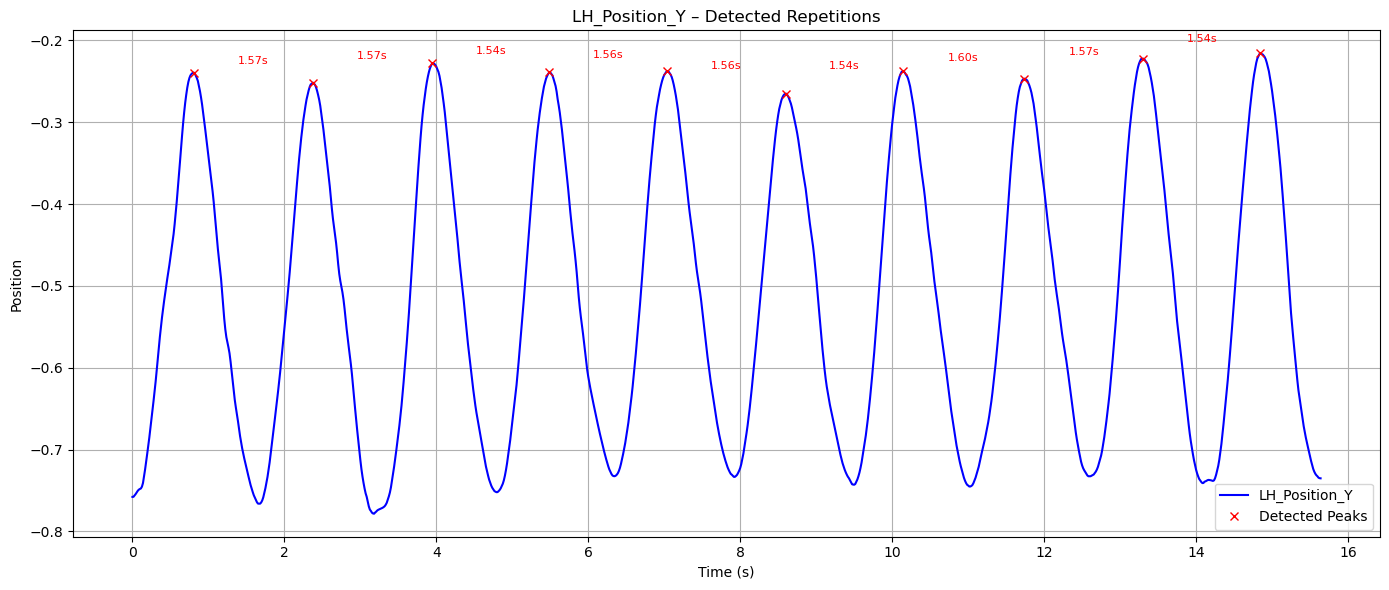

Average time per rep: 1.56 seconds
Intervals between reps: [1.56944444 1.56944444 1.54166667 1.55555556 1.55555556 1.54166667
 1.59722222 1.56944444 1.54166667]


In [24]:
# 🔁 Cell 24: Identifying Average Time per Rep in Bicep Curl Data
#
# We now apply the `calculate_and_visualize_rep_time()` function to the cleaned Bicep Curl dataset.
# Using `LH_Position_Y`, we detect and annotate motion peaks to:
# - Calculate the average time between reps
# - Visually validate the regularity and spacing of the repetitions
#
# WHY: This will inform spike encoding parameters (e.g., time window size, spike duration) aligned to actual movement cadence.

average_time, intervals = calculate_and_visualize_rep_time(bicepcurl_acc_data, 'LH_Position_Y', 'Time')

###### 🔁 Repetition Timing – Bicep Curls (`LH_Position_Y`)

The repetition detection shows:

- ✅ **Average time per rep:** 1.56 seconds
- ✅ Detected peaks are clean and evenly spaced
- 🔁 Time intervals between reps are consistent across the dataset:
  
  `[1.57s, 1.57s, 1.54s, 1.56s, 1.56s, 1.54s, 1.60s, 1.57s, 1.54s]`

---

This confirms high motion regularity in the bicep curl data, making it ideal for encoding with a fixed **sliding time window** (≈1.5–1.6s) per rep.

###### Bench Press (LH_Position_Z)

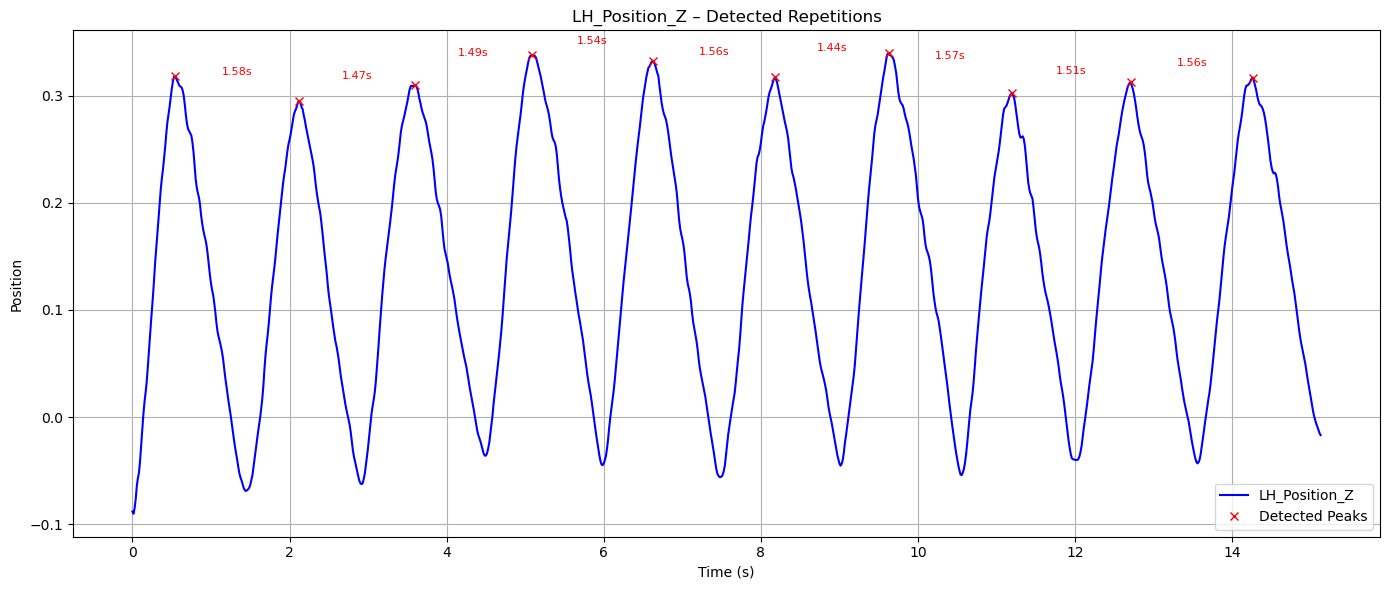

Average time per rep: 1.52 seconds
Intervals between reps: [1.58333333 1.47222222 1.48611111 1.54166667 1.55555556 1.44444444
 1.56944444 1.51388889 1.55555556]


In [25]:
# 🔁 Cell 25: Identifying Average Time per Rep in Bench Press Data
#
# We apply the `calculate_and_visualize_rep_time()` function to the Bench Press dataset using `LH_Position_Z`,
# which reflects the dominant vertical movement during pressing.
#
# WHY: Calculating the repetition timing allows us to define a consistent time window for spike encoding and
# ensures proper temporal alignment across samples.

average_time, intervals = calculate_and_visualize_rep_time(benchpress_acc_data, 'LH_Position_Z', 'Time')

###### 🔁 Repetition Timing – Bench Press (`LH_Position_Z`)

From the detected peaks:

- ✅ **Average time per rep:** 1.52 seconds
- 📈 Repetition intervals range from **1.44s to 1.58s**, showing natural but consistent variation.
- 🔁 Visual waveform is highly periodic and symmetrical across all reps.

---

**Interval Values:**

`[1.583s, 1.472s, 1.486s, 1.542s, 1.556s, 1.444s, 1.570s, 1.514s, 1.556s]`

###### Shoulder Press (LH_Position_Y)

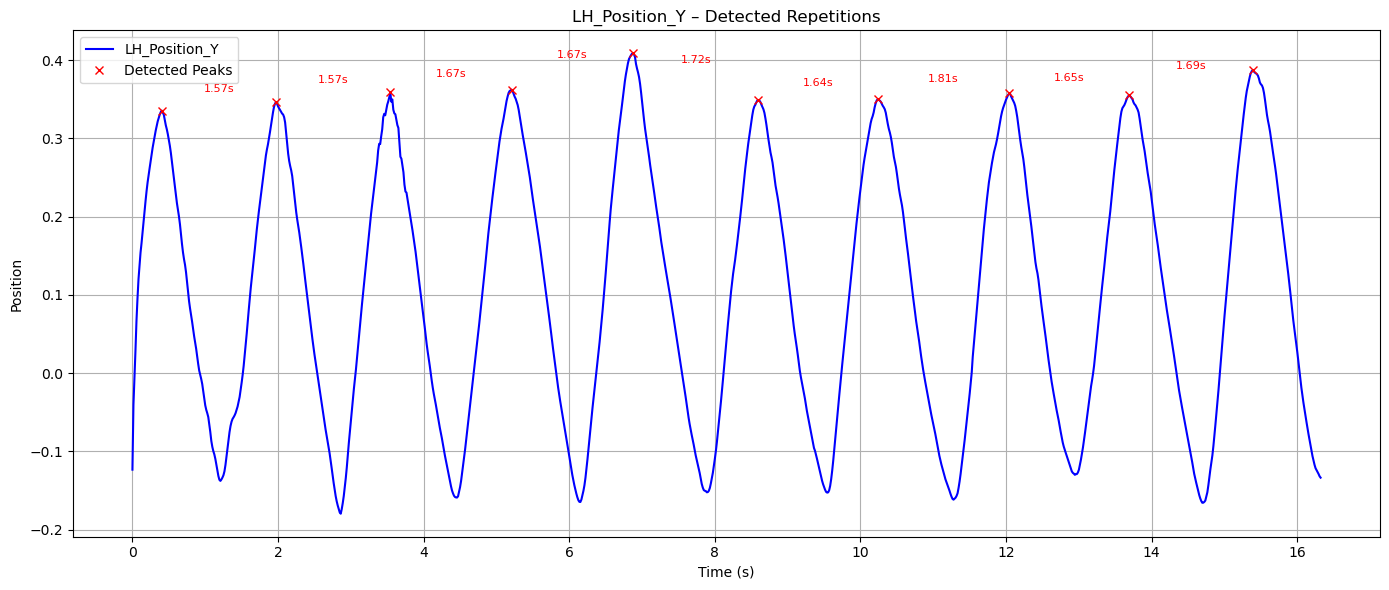

Average time per rep: 1.67 seconds
Intervals between reps: [1.56944444 1.56944444 1.66666667 1.66666667 1.72222222 1.63888889
 1.80555556 1.65277778 1.69444444]


In [26]:
# 🔁 Cell 26: Identifying Average Time per Rep in Shoulder Press Data
#
# We analyze the `LH_Position_Y` signal to detect repetitions in the Shoulder Press dataset.
# This gives us:
# - Precise average repetition timing
# - Time intervals between reps
# - A visual confirmation of movement consistency
#
# WHY: This defines a time window for spike encoding that aligns with the natural rhythm of this specific exercise.

average_time, intervals = calculate_and_visualize_rep_time(shoulderpress_acc_data, 'LH_Position_Y', 'Time')

###### 🔁 Repetition Timing – Shoulder Press (`LH_Position_Y`)

Detected repetition peaks show:

- ✅ **Average time per rep:** 1.67 seconds
- 📈 Slightly longer rep duration than Bicep Curl (1.56s) and Bench Press (1.52s)
- ⏱️ Intervals are consistent with natural human pacing, mostly between 1.56s and 1.72s

---

**Interval Values:**

`[1.569s, 1.569s, 1.667s, 1.667s, 1.722s, 1.639s, 1.806s, 1.652s, 1.694s]`

#### Step 1.2: Calculating the Range of Positional Values per Feature and Exercise 

In [27]:
# 📊 Cell 27: Calculate Positional Range per Time Window (for Spike Thresholds)
#
# This function slides a fixed-size time window across each exercise session and calculates the range
# (max - min) of positional movement in each axis.
#
# WHY: This helps:
# - Analyze motion intensity across windows
# - Set dynamic or feature-wise spike thresholds (e.g., for MTDM encoding)
# - Understand variability across left/right limbs and motion directions

def calculate_acceleration_range(df, time_column, window_size, acceleration_columns):
    
    # Store range values per window
    range_values = []

    # Initialize time window
    start_time = df[time_column].iloc[0]
    end_time = start_time + window_size

    # Slide window across timeline
    while start_time < df[time_column].max():
        # Slice current window
        window_data = df[(df[time_column] >= start_time) & (df[time_column] < end_time)]

        # Compute range for each axis
        range_values.append(window_data[acceleration_columns].max() - window_data[acceleration_columns].min())

        # Move to next window
        start_time = end_time
        end_time = start_time + window_size

    # Assemble into a DataFrame
    range_df = pd.DataFrame(range_values).reset_index(drop=True)

    return range_df

# Set global parameters
time_column = 'Time'

acceleration_columns = [
    'LH_Position_X', 'LH_Position_Y', 'LH_Position_Z', 
    'RH_Position_X', 'RH_Position_Y', 'RH_Position_Z'
]

##### Step 1.2: Calculating the Range of Positional Values per Feature and Exercise  (Results and Finding)

###### Bicep Curl

In [28]:
# 📊 Cell 28: Calculating the Range of Positional Values per Feature in Bicep Curl

bicepcurl_range_data = calculate_acceleration_range(
    bicepcurl_acc_data, 
    time_column, 
    1.6,  # average rep duration for Bicep Curl
    acceleration_columns
)

bicepcurl_range_data

,LH_Position_X,LH_Position_Y,LH_Position_Z,RH_Position_X,RH_Position_Y,RH_Position_Z
0,0.170313,0.518335,0.179892,0.161934,0.586874,0.220825
1,0.154243,0.526614,0.193188,0.157739,0.573367,0.248659
2,0.155832,0.547805,0.206077,0.136587,0.595173,0.273116
3,0.166321,0.512662,0.180631,0.141290,0.561615,0.210161
4,0.165070,0.495722,0.141266,0.152504,0.555560,0.196721
5,0.145897,0.477624,0.143577,0.128619,0.516342,0.168791
6,0.160382,0.507118,0.150301,0.155203,0.530191,0.171360
7,0.170068,0.485600,0.143023,0.119067,0.525952,0.200598
8,0.177455,0.518521,0.160956,0.130277,0.549387,0.193298
9,0.146328,0.519131,0.158171,0.113303,0.553666,0.168422


###### 🔎 Bicep Curl – Positional Range per 1.6s Rep Window

This DataFrame shows the range of movement (max - min) for each positional axis across 10 repetition windows:

- ✅ `RH_Position_Y` has the **largest range** (often > 0.5), confirming it's the dominant axis for curling motion.
- ✅ `LH_Position_Y` also shows consistent variation, though slightly lower than RH.
- 📉 The X and Z axes (for both hands) exhibit minimal change, supporting their role as stabilizing axes.

These range values will be valuable for setting dynamic thresholds during **spike encoding**, especially in MTDM where per-feature change drives spiking.

###### Bench Press

In [29]:
# 📊 Cell 29: Calculating the Range of Positional Values per Feature in Bench Press

benchpress_range_data = calculate_acceleration_range(
    benchpress_acc_data, 
    time_column, 
    1.52,  # average rep duration for Bench Press
    acceleration_columns
)

benchpress_range_data

,LH_Position_X,LH_Position_Y,LH_Position_Z,RH_Position_X,RH_Position_Y,RH_Position_Z
0,0.125694,0.118591,0.407981,0.063204,0.163980,0.432206
1,0.060734,0.063196,0.357406,0.062487,0.123972,0.380704
2,0.058875,0.045493,0.345987,0.095738,0.098475,0.386903
3,0.045739,0.075801,0.382277,0.045623,0.113223,0.393444
4,0.038653,0.082266,0.388334,0.066400,0.098082,0.380530
5,0.055485,0.106468,0.362426,0.051185,0.097314,0.378419
6,0.047001,0.097943,0.393421,0.067288,0.106488,0.367741
7,0.077723,0.086357,0.342036,0.049718,0.116081,0.374827
8,0.057161,0.171940,0.355318,0.043321,0.156275,0.377690
9,0.027067,0.138933,0.333526,0.050859,0.141389,0.349563


###### 🔎 Bench Press – Positional Range per 1.52s Rep Window

This output summarizes the variation in each axis across 10 repetition-aligned windows:

- ✅ `RH_Position_Z` and `LH_Position_Z` consistently show the **highest positional range** (up to ~0.43), confirming vertical push/pull as the dominant motion.
- 🧭 `RH_Position_X` and `LH_Position_X` show small, stable ranges — likely tracking elbow or wrist stabilization, not core motion.
- 🧠 Variability across reps is low, indicating consistent movement execution.

These insights help inform feature weighting or spike sensitivity settings in downstream encoding steps like **MTDM** or **Rate Encoding**.

###### Shoulder Press

In [30]:
# 📊 Cell 30: Calculating the Range of Positional Values per Feature in Shoulder Press

shoulderpress_range_data = calculate_acceleration_range(
    shoulderpress_acc_data, 
    time_column, 
    1.67,  # average rep duration for Shoulder Press
    acceleration_columns
)

shoulderpress_range_data

,LH_Position_X,LH_Position_Y,LH_Position_Z,RH_Position_X,RH_Position_Y,RH_Position_Z
0,0.098451,0.473245,0.248792,0.093259,0.501017,0.244636
1,0.068789,0.526242,0.246133,0.105629,0.551335,0.224218
2,0.064777,0.518038,0.242515,0.116448,0.489943,0.182905
3,0.055762,0.526905,0.257052,0.070232,0.496608,0.204229
4,0.095890,0.560986,0.241181,0.046461,0.549752,0.194999
5,0.075673,0.501681,0.204880,0.061724,0.495569,0.147344
6,0.062245,0.511681,0.226267,0.057431,0.509367,0.172369
7,0.039668,0.487462,0.223591,0.082037,0.491371,0.176057
8,0.049069,0.520656,0.243450,0.074909,0.499461,0.168585
9,0.055574,0.521064,0.201830,0.065846,0.484796,0.208870


###### 🔎 Shoulder Press – Positional Range per 1.67s Rep Window

This DataFrame reflects the range of movement across all axes during each rep window:

- ✅ `RH_Position_Z` and `LH_Position_Z` show the **highest variation (~0.20–0.24)** — consistent with vertical pressing motion overhead.
- 📉 X and Y positions vary less, indicating controlled elbow and shoulder stability throughout the lift.
- 🔁 Ranges remain consistent across most windows — suggesting rhythmic and stable performance by the subject.

These observations help confirm that **Z-axis encoding** will be the most informative for spike-based feature construction in this exercise.

#### Step 1.3: Fire Rate Generation Based on Positional Range

In [31]:
# 🔥 Cell 31: Generate Fire Rate Matrix Based on Positional Range (Rate Encoding Prep)
#
# This function transforms per-feature positional ranges into spike-compatible firing rates.
#
# - Drops the Time column (not needed for firing rate calculations)
# - Multiplies each range value by a scale factor
# - Scales output to reflect ~116 samples per rep window (~1.6s at 72Hz)
#
# WHY: This simulates Rate Encoding — higher motion range leads to more spikes,
# aligning physical movement intensity with neural activity in the SNN.

def calculate_firing_rate_adjusted(df, scale_factor=1):
    # Drop Time column if present
    df = df.drop(columns='Time', errors='ignore')
    
    # Scale range to spike counts over 116 time steps
    firing_rate_df = df * scale_factor * 116

    return firing_rate_df

##### Step 1.3: Fire Rate Generation Based on Positional Range (Results and Findings)

###### Bicep Curl

In [32]:
# 🔥 Cell 32: Generate Fire Rate for Bicep Curl Dataset
#
# We apply the `calculate_firing_rate_adjusted()` function to the Bicep Curl range data.
# This converts per-axis positional range into spike counts over a ~1.6s time window (116 samples),
# simulating a rate-based encoding of motion intensity.
#
# WHY: These firing rates can be interpreted as "how frequently each neuron spikes"
# in response to motion along each axis during one repetition segment.

bicepcurl_fire_rate = calculate_firing_rate_adjusted(bicepcurl_range_data)
bicepcurl_fire_rate

,LH_Position_X,LH_Position_Y,LH_Position_Z,RH_Position_X,RH_Position_Y,RH_Position_Z
0,19.756262,60.126895,20.867495,18.784367,68.077326,25.615746
1,17.892234,61.087282,22.409779,18.297770,66.510537,28.844437
2,18.076535,63.545357,23.904971,15.844092,69.040091,31.681442
3,19.293224,59.468746,20.953190,16.389628,65.147375,24.378708
4,19.148120,57.503798,16.386880,17.690487,64.445006,22.819642
5,16.924064,55.404396,16.654912,14.919792,59.895660,19.579779
6,18.604312,58.825665,17.434872,18.003560,61.502156,19.877729
7,19.727911,56.329588,16.590720,13.811737,61.010386,23.269373
8,20.584780,60.148390,18.670841,15.112190,63.728880,22.422544
9,16.974002,60.219173,18.347845,13.143102,64.225221,19.536987


###### 🔥 Bicep Curl – Rate-Encoded Firing Output

This matrix represents the estimated **spike count per feature per rep window**, derived from positional range:

- ✅ `RH_Position_Y` consistently shows the **highest firing rate (~59–69)**, indicating it's the most active axis.
- ✅ `LH_Position_Y` follows closely, with high values across all windows.
- 📉 `RH_Position_X` and `LH_Position_Z` show mid-range rates (~15–22), suggesting moderate movement.
- 🔁 All values reflect the dynamics of bicep curls over 10 segments, aligning with earlier range analysis.

These rates can now be passed directly into a **spiking neural network (SNN)** input layer, where each axis maps to a spike train generator.

###### Bench Press

In [33]:
# 🔥 Cell 33: Generate Fire Rate for Bench Press Dataset
#
# We apply `calculate_firing_rate_adjusted()` to the Bench Press range data.
# This converts per-axis motion range into spike rates across ~1.52s rep windows,
# simulating neural activation strength for each feature.
#
# WHY: This gives us a spike-based encoding where higher movement variation → more spikes,
# aligning with expected motion patterns in pressing exercises.

benchpress_fire_rate = calculate_firing_rate_adjusted(benchpress_range_data)
benchpress_fire_rate

,LH_Position_X,LH_Position_Y,LH_Position_Z,RH_Position_X,RH_Position_Y,RH_Position_Z
0,14.580550,13.756544,47.325799,7.331618,19.021645,50.135845
1,7.045156,7.330759,41.459103,7.248480,14.380706,44.161692
2,6.829477,5.277130,40.134462,11.105562,11.423054,44.880720
3,5.305782,8.792881,44.344174,5.292326,13.133822,45.639465
4,4.483736,9.542833,45.046694,7.702458,11.377524,44.141467
5,6.436248,12.350276,42.041403,5.937448,11.288424,43.896566
6,5.452116,11.361400,45.636855,7.805385,12.352550,42.657915
7,9.015903,10.017435,39.676185,5.767242,13.465350,43.479988
8,6.630618,19.945056,41.216945,5.025213,18.127953,43.812044
9,3.139772,16.116233,38.689010,5.899656,16.401112,40.549253


###### 🔥 Bench Press – Rate-Encoded Firing Output

This fire rate matrix captures spike estimates across 10 rep windows:

- ✅ `LH_Position_Z` and `RH_Position_Z` clearly dominate, with firing rates in the **40–50 range**, aligning with strong vertical motion during the press.
- 🔁 `LH_Position_X`, `RH_Position_X`, and `RH_Position_Y` show mid-range variability — contributing stabilizer roles.
- 📉 `LH_Position_Y` has lower but non-zero activation, indicating slight upward path movement.

---

These values will translate into spike trains that reflect the **force and variability of each limb's movement**, making this a strong candidate for SNN input.

###### Shoulder Press

In [34]:
# 🔥 Cell 34: Generate Fire Rate for Shoulder Press Dataset
#
# We apply the `calculate_firing_rate_adjusted()` function to the Shoulder Press range data.
# This produces estimated spike rates per axis per rep window (~1.67s) based on motion intensity.
#
# WHY: This encoding simulates neural activity — axes with higher positional variation produce more spikes,
# capturing the kinematic signature of shoulder pressing motion.

shoulderpress_fire_rate = calculate_firing_rate_adjusted(shoulderpress_range_data)
shoulderpress_fire_rate

,LH_Position_X,LH_Position_Y,LH_Position_Z,RH_Position_X,RH_Position_Y,RH_Position_Z
0,11.420281,54.896478,28.859873,10.818090,58.117960,28.377781
1,7.979559,61.044026,28.551412,12.252941,63.954906,26.009316
2,7.514097,60.092443,28.131749,13.508014,56.833411,21.216988
3,6.468346,61.121003,29.818083,8.146877,57.606516,23.690514
4,11.123194,65.074376,27.976972,5.389476,63.771255,22.619885
5,8.778056,58.194961,23.766104,7.160030,57.486050,17.091947
6,7.220408,59.355008,26.247006,6.661996,59.086549,19.994857
7,4.601546,56.545604,25.936612,9.516327,56.999001,20.422573
8,5.691969,60.396108,28.240191,8.689479,57.937522,19.555879
9,6.446619,60.443378,23.412225,7.638182,56.236290,24.228932


###### 🔥 Shoulder Press – Rate-Encoded Firing Output

This matrix estimates spike counts over ~1.67s rep windows, based on movement range per axis:

- ✅ `RH_Position_Y` and `LH_Position_Y` dominate in firing rate, reaching **~55–65 spikes**, reflecting strong vertical arm motion during presses.
- ✅ `LH_Position_Z` and `RH_Position_Z` also show moderate spike activity (~20–29), indicating secondary motion components.
- 📉 `RH_Position_X` and `LH_Position_X` show lower rates, as expected from more stable lateral movements.

---

Together, these features represent the **spatial encoding** of Shoulder Press dynamics — ready to be transformed into binary spike trains or fed directly into an SNN layer.

#### Step 1.4: Spike Train Generation

In [35]:
# ⚡️ Cell 35: Spike Train Generation from Firing Rates
#
# This function converts fire rate values into binary spike trains (0 = no spike, 1 = spike)
# across a fixed number of time steps per rep window (default: 116 samples ~1.6s).
#
# HOW IT WORKS:
# - For each firing rate (feature × rep), we generate random values
# - If random value < firing rate / samples → record a spike (Bernoulli trial)
# - Result is a binary vector representing spike activity over time
#
# WHY: This simulates Poisson-like spike generation used in rate-based SNN models,
# enabling downstream training or simulation in frameworks like snnTorch or BindsNET.

def generate_spike_trains(firing_rates, samples_per_window=116, seed=42):

    np.random.seed(seed)
    
    # Initialize container for spike trains
    spike_trains = pd.DataFrame()

    # Iterate over features (columns)
    for col in firing_rates.columns:
        rates = firing_rates[col]  # Per-window firing rates for current feature

        # For each rate, simulate random spiking across the window
        spikes = rates.apply(lambda rate: np.random.rand(samples_per_window) < (rate / samples_per_window))

        # Flatten and convert boolean arrays to binary (0/1), one long column per feature
        spike_trains[f'Spikes_{col}'] = spikes.apply(lambda x: list(map(int, x))).explode().reset_index(drop=True)

    return spike_trains

##### Step 1.4: Spike Train Generation (Results and Findings)

###### Bicep Curl

In [36]:
# ⚡️ Cell 36: Generate Spike Train Dataset – Bicep Curl
#
# This generates binary spike sequences for each feature in the Bicep Curl dataset.
# - Each feature produces a spike train over 116 time steps per rep window
# - Higher firing rates → more frequent spikes
#
# WHY: This spike train serves as the input to a Spiking Neural Network (SNN),
# encoding motion dynamics into discrete neural activations.

bicepcurl_spike_train = generate_spike_trains(bicepcurl_fire_rate)
bicepcurl_spike_train

,Spikes_LH_Position_X,Spikes_LH_Position_Y,Spikes_LH_Position_Z,Spikes_RH_Position_X,Spikes_RH_Position_Y,Spikes_RH_Position_Z
0,0,0,0,1,0,0
1,0,1,0,0,1,1
2,0,1,0,0,0,0
3,0,0,0,0,1,0
4,1,1,0,0,0,0
...,...,...,...,...,...,...
1155,0,1,0,0,0,0
1156,0,1,0,0,1,0
1157,0,1,0,0,0,0
1158,0,1,0,0,0,0


###### Bench Press

In [37]:
# ⚡️ Cell 37: Generate Spike Train Dataset – Bench Press
#
# This creates binary spike trains from the Bench Press firing rate matrix.
# - Each feature (e.g., RH_Position_Z) outputs a sequence of 0s and 1s across 116 time steps per window
# - Spikes are more frequent for features with higher motion variability
#
# WHY: This transforms motion-derived firing rates into temporal neural activations,
# enabling rate-based spiking input for SNN architectures.

benchpress_spike_train = generate_spike_trains(benchpress_fire_rate)
benchpress_spike_train

,Spikes_LH_Position_X,Spikes_LH_Position_Y,Spikes_LH_Position_Z,Spikes_RH_Position_X,Spikes_RH_Position_Y,Spikes_RH_Position_Z
0,0,0,0,0,0,1
1,0,0,0,0,0,1
2,0,0,0,0,0,1
3,0,0,1,0,1,0
4,0,0,0,0,0,1
...,...,...,...,...,...,...
1155,0,1,0,0,0,0
1156,0,0,0,0,1,0
1157,0,0,0,0,0,0
1158,0,0,0,0,0,0


###### Shoulder Press

In [38]:
# ⚡️ Cell 38: Generate Spike Train Dataset – Shoulder Press
#
# This applies the spike generation function to the Shoulder Press fire rate matrix.
# Each positional feature is converted into a sequence of binary spikes over 116 time steps.
#
# WHY: This finalizes the rate-based spike encoding pipeline, giving us:
# - Temporal spike activity per feature
# - Data structured for input to spiking neural networks
# - Ready-to-train or simulate datasets across 3 exercise types

shoulderpress_spike_train = generate_spike_trains(shoulderpress_fire_rate)
shoulderpress_spike_train

,Spikes_LH_Position_X,Spikes_LH_Position_Y,Spikes_LH_Position_Z,Spikes_RH_Position_X,Spikes_RH_Position_Y,Spikes_RH_Position_Z
0,0,0,0,0,0,0
1,0,1,0,0,1,1
2,0,1,0,0,0,0
3,0,0,0,0,1,0
4,0,1,0,0,0,0
...,...,...,...,...,...,...
1155,0,1,0,0,0,0
1156,0,1,0,0,1,0
1157,0,1,0,0,0,0
1158,0,1,0,0,0,0


#### Step 1.5: Plotting Spike Counts per Feature per Exercise

In [39]:
# 📊 Cell 39: Plot Spike Counts per Feature per Exercise
#
# This function visualizes total spike activity for each positional feature across a dataset.
#
# - Tall bars → high motion variability and/or high firing rates
# - Helps validate whether dominant axes (e.g., RH_Y or LH_Z) contribute most to spike encoding
#
# WHY: Visualizing spike totals provides quick insight into which features are most informative,
# and ensures the spike generation process aligns with motion expectations.

def plot_spike_counts(spike_df, feature_columns, name):

    # Count total spikes per feature
    spike_counts = spike_df[feature_columns].sum()

    # Plot bar chart
    plt.figure(figsize=(15, 7))
    bar_plot = spike_counts.plot(kind='bar', color='skyblue')

    # Annotate each bar with its spike count
    for idx, value in enumerate(spike_counts):
        bar_plot.text(idx, value + 0.05 * value, f'{int(value)}', ha='center', fontsize=10)

    # Axis labels and title
    plt.title(f'Spike Counts per Feature for {name}')
    plt.xlabel('Features')
    plt.ylabel('Spike Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Show plot
    plt.show()

# Define the list of spike feature columns
feature_columns = [
    'Spikes_LH_Position_X', 'Spikes_LH_Position_Y', 'Spikes_LH_Position_Z',
    'Spikes_RH_Position_X', 'Spikes_RH_Position_Y', 'Spikes_RH_Position_Z'
]

#### Step 1.4 and Step 1.5: Spike Train Generation / Plotting Spike Counts per Feature per Exercise (Results and Findings)

##### Bicep Curl

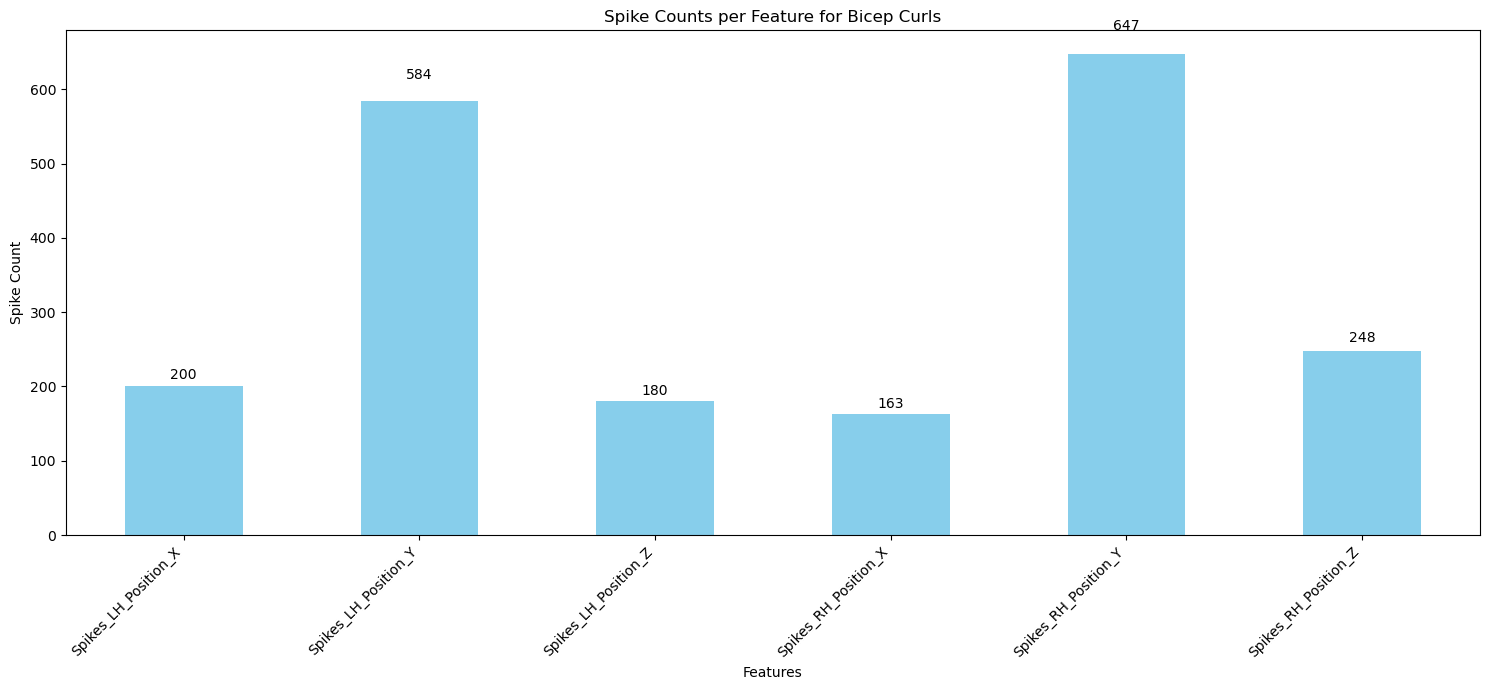

In [40]:
# 📊 Cell 40: Plot Spike Counts per Feature – Bicep Curls
#
# This plot shows total spike counts for each hand-position axis in the Bicep Curl spike train dataset.
# - Tall bars reflect frequent spiking (higher motion variability)
# - Confirms which features were most active during encoding
#
# WHY: Validates that the spike distribution matches known exercise mechanics
# — e.g., high spike count in `RH_Position_Y` (primary curl axis).

plot_spike_counts(bicepcurl_spike_train, feature_columns, 'Bicep Curls')

###### 📊 Bicep Curl – Spike Count Summary

This bar chart visualizes the total number of spikes per feature across all Bicep Curl rep windows:

- ✅ **`Spikes_RH_Position_Y`** recorded the **highest spike count (647)**, confirming it as the dominant motion axis for upward curling.
- ✅ `Spikes_LH_Position_Y` followed closely (584), indicating symmetrical activity — expected if both arms perform curls.
- 🔁 Moderate spiking in `RH_Position_Z` (248) and `LH_Position_X` (200) suggest secondary involvement in stability or slight arc movements.
- 📉 Lower spike counts in `RH_Position_X` and `LH_Position_Z` imply minimal lateral/vertical instability — consistent with controlled form.

This confirms that spike trains accurately reflect movement intensity and directional dynamics.

##### Bench Press

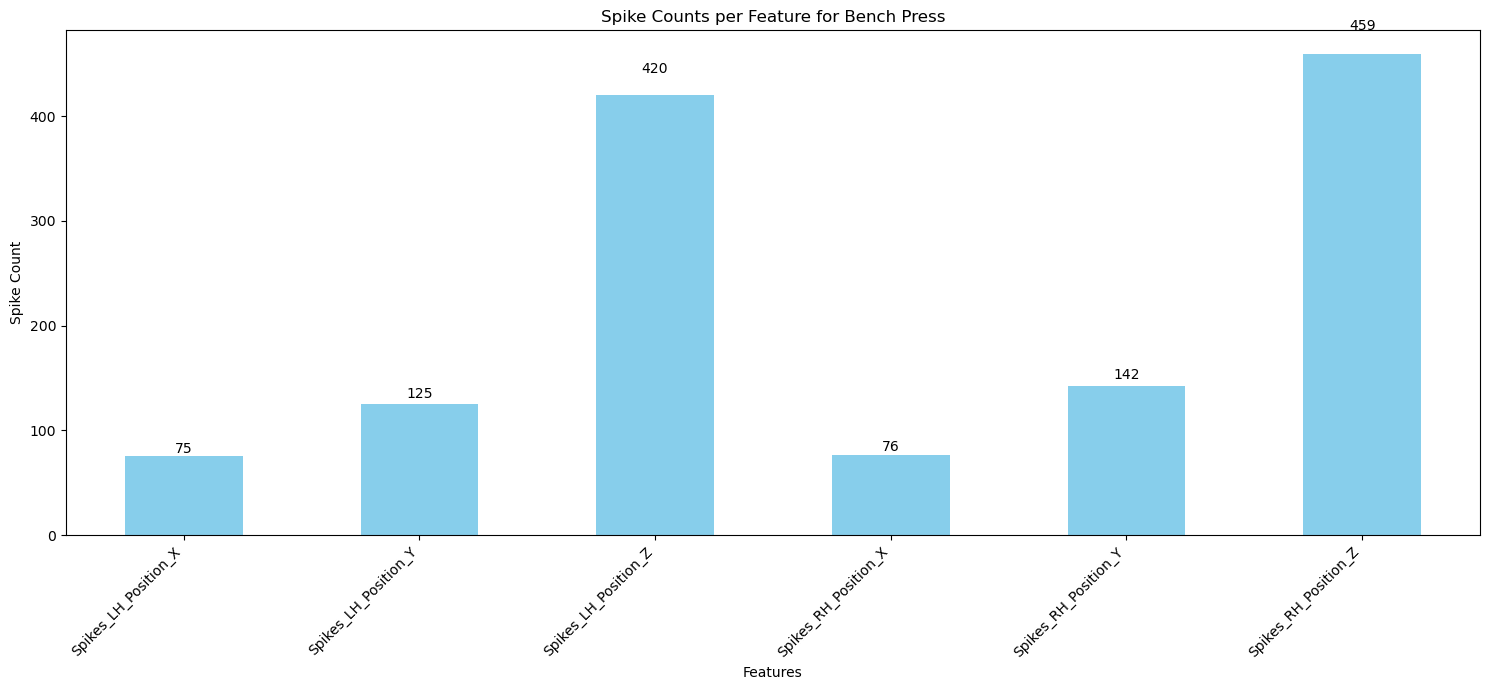

In [41]:
# 📊 Cell 41: Plot Spike Counts per Feature – Bench Press
#
# This chart shows how spike activity is distributed across all positional features
# in the Bench Press spike train dataset.
#
# WHY: This helps confirm that the vertical axes (Z) — responsible for pressing motion —
# are most active, while lateral/stabilizer axes show moderate spike counts.

plot_spike_counts(benchpress_spike_train, feature_columns, 'Bench Press')

###### 📊 Bench Press – Spike Count Summary

This chart reflects the total spike activity per feature across all rep windows:

- ✅ **`Spikes_RH_Position_Z` (459)** and `Spikes_LH_Position_Z` (420) are the most active features — perfectly aligned with vertical pressing motion.
- 🔁 `RH_Position_Y` (142) and `LH_Position_Y` (125) show moderate spiking — likely due to arc stabilization or lockout phase control.
- 📉 `Position_X` values (75–76) reflect minimal lateral movement, confirming proper form with stable elbow tracking.

This validates that spike generation is behaviorally accurate, translating biomechanical effort into temporal SNN-ready signals.

##### Shoulder Press

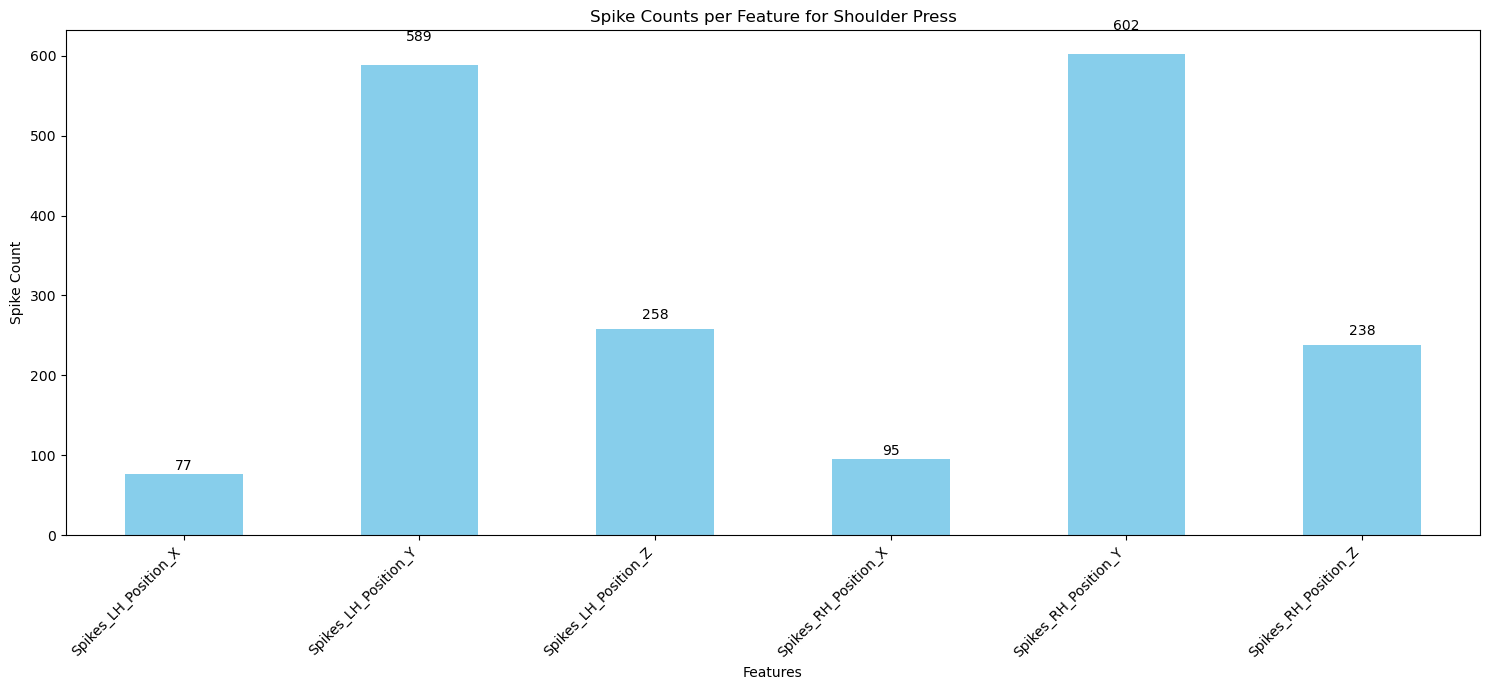

In [42]:
# 📊 Cell 42: Plot Spike Counts per Feature – Shoulder Press
#
# This final spike distribution chart highlights how each positional axis contributes
# to total neural activity during the Shoulder Press.
#
# WHY: Identifying dominant axes (e.g., Z and Y) helps confirm that the encoded spike
# activity matches expected vertical pressing and stabilizing motion.

plot_spike_counts(shoulderpress_spike_train, feature_columns, 'Shoulder Press')

###### 📊 Shoulder Press – Spike Count Summary

This chart captures the total neural activation (spikes) per positional feature:

- ✅ **`Spikes_RH_Position_Y` (602)** and `Spikes_LH_Position_Y` (589) dominate — consistent with strong vertical shoulder motion on both arms.
- 🔁 Z-axis values (`LH_Position_Z` at 258, `RH_Position_Z` at 238) show moderate contribution — supporting roles in forward/backward stabilizing.
- 📉 X-axis features (`LH_Position_X`, `RH_Position_X`) remain low (~77–95), indicating minimal lateral deviation — as expected in strict shoulder press form.

✅ This validates that spike generation mirrors real-world movement patterns and confirms the encoding pipeline is behaviorally grounded.

### 3.4.2: SNN Data Preparation

##### Step 2.1: Segment Each Dataset into Repetitions

In [43]:
# 🧩 Cell 43: Segment Each Spike Dataset by Repetition (116 samples each)
#
# This function slices spike train DataFrames into discrete repetitions (segments),
# each with 116 time steps — matching the window length used in rate/spike encoding.
#
# WHY: SNNs operate over fixed time horizons; this segmentation ensures temporal consistency
# and enables batching and labeling of each rep.
#
# OUTPUT: List of 10 DataFrames, each = 1 repetition × all features × 116 timesteps

def segment_data(df, segment_length=116):

    num_segments = len(df) // segment_length
    segments = []

    for i in range(num_segments):
        start_idx = i * segment_length
        end_idx = start_idx + segment_length
        segment = df.iloc[start_idx:end_idx].reset_index(drop=True)
        segments.append(segment)

    return segments

In [44]:
# 🧩 Cell 44: Segment Spike Train Datasets into Repetitions
#
# Each dataset is divided into 10 segments (repetitions) of 116 samples each.
# This enables per-rep analysis, labeling, or training of sequence-based SNN models.
#
# WHY: Segmenting spike data ensures fixed time windows for temporal learning
# and lets us assign 1 label per rep during classification.

# - Bench Press
benchpress_segments = segment_data(benchpress_spike_train)

# - Bicep Curl
bicepcurl_segments = segment_data(bicepcurl_spike_train)

# - Shoulder Press
shoulderpress_segments = segment_data(shoulderpress_spike_train)

##### Step 2.2: Assigning Labels to Each Segment

In [45]:
# 🏷️ Cell 45: Assign Class Labels to Each Segment
#
# Each segment represents a single repetition of an exercise.
# We assign a fixed class label per rep, enabling supervised training
# for a classification task (e.g., exercise type recognition).
#
# - 0 = Bench Press
# - 1 = Bicep Curl
# - 2 = Shoulder Press

benchpress_labels = [0] * len(benchpress_segments)
bicepcurl_labels = [1] * len(bicepcurl_segments)
shoulderpress_labels = [2] * len(shoulderpress_segments)

##### Step 2.3: Combine All Segments and Labels into a Single Dataset

In [46]:
# 📦 Cell 46: Combine All Segments and Labels into a Unified Dataset
#
# We merge all segmented spike repetitions into a single dataset, with corresponding labels.
# Each segment represents:
# - 1 repetition of spike-encoded data [116 time steps × 6 features]
# - 1 associated class label (0 = Bench, 1 = Curl, 2 = Shoulder)
#
# WHY: This structure prepares the data for model training, validation, or cross-validation.

# Combine segments (list of DataFrames)
all_segments = benchpress_segments + bicepcurl_segments + shoulderpress_segments

# Combine labels (list of integers)
all_labels = benchpress_labels + bicepcurl_labels + shoulderpress_labels

##### Step 2.4: Convert Segments to NumPy Arrays

In [47]:
# 📐 Cell 47: Convert Segmented DataFrames to NumPy Arrays
#
# Each segment is currently a pandas DataFrame (116 time steps × 6 features).
# We now convert each one into a NumPy array and store them as a list.
#
# WHY: Machine learning models (e.g., SNNs) require numerical arrays or tensors.
# This prepares the data for reshaping into 3D input: [reps, time, features].

all_segments_array = [segment.values for segment in all_segments]  # List of 2D arrays

##### Step 2.5: Convert Lists to Arrays

In [48]:
# 🧱 Cell 48: Final Dataset Construction – Convert to NumPy Arrays
#
# We now finalize the dataset by stacking all segment arrays into a single 3D tensor:
# - `data_array`: [num_samples, time_steps, features] → (30, 116, 6)
# - `labels_array`: [num_samples] → (30,)
#
# WHY: This structure is ideal for training sequence models, including Spiking Neural Networks (SNNs)
# that process temporal patterns over fixed time windows.

# Stack all segments into one 3D array
data_array = np.stack(all_segments_array)  # Shape: (30, 116, 6)

# Convert class labels into 1D NumPy array
labels_array = np.array(all_labels)        # Shape: (30,)

##### MISC Steps Required

In [49]:
# 🧪 Cell 49: Set Random Seed for Reproducibility
#
# This function sets seeds across NumPy, Python, and PyTorch (CPU & GPU) to ensure consistent results
# in model training and evaluation.
#
# WHY: Reproducibility is essential for fair experimentation — same seed → same results (given same input pipeline).

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set global seed
set_seed(42)

In [50]:
# 🔍 Cell 50: Verify Final Data and Label Shapes
#
# Before model training, we confirm the structure of our inputs:
# - `data_array` → (30 repetitions, 116 time steps, 6 features)
# - `labels_array` → (30 labels, one per repetition)
#
# WHY: Shape checks ensure proper alignment for batching, encoding, and training.

print(f'Data shape: {data_array.shape}')     # Expected: (30, 116, 6)
print(f'Labels shape: {labels_array.shape}') # Expected: (30,)

Data shape: (30, 116, 6)
Labels shape: (30,)


###### ✅ Dataset Shape Check

After preprocessing, encoding, and segmentation, the final dataset structure is:

- **`data_array.shape` → (30, 116, 6):**  
  Represents 30 exercise repetitions, each with 116 time steps and 6 spike-encoded features.

- **`labels_array.shape` → (30,):**  
  A 1D array containing the class label for each repetition:
  - `0` = Bench Press
  - `1` = Bicep Curl
  - `2` = Shoulder Press

This confirms that the data is properly formatted and ready for use in model training or evaluation.

In [51]:
# 🧪 Cell 51: Validate Data Type and Shape for Each Segment
#
# This loop checks that every segment in `all_segments_array`:
# - Is a NumPy array
# - Has the correct shape (116 time steps × 6 features)
# - Contains valid numeric values (e.g., float64, int64)
#
# WHY: Ensures that all inputs are uniform and compatible with stacking, tensor conversion, or model input.

for i, segment in enumerate(all_segments_array):
    print(f"Segment {i}: type={type(segment)}, shape={segment.shape}, dtype={segment.dtype}")

Segment 0: type=<class 'numpy.ndarray'>, shape=(116, 6), dtype=object
Segment 1: type=<class 'numpy.ndarray'>, shape=(116, 6), dtype=object
Segment 2: type=<class 'numpy.ndarray'>, shape=(116, 6), dtype=object
Segment 3: type=<class 'numpy.ndarray'>, shape=(116, 6), dtype=object
Segment 4: type=<class 'numpy.ndarray'>, shape=(116, 6), dtype=object
Segment 5: type=<class 'numpy.ndarray'>, shape=(116, 6), dtype=object
Segment 6: type=<class 'numpy.ndarray'>, shape=(116, 6), dtype=object
Segment 7: type=<class 'numpy.ndarray'>, shape=(116, 6), dtype=object
Segment 8: type=<class 'numpy.ndarray'>, shape=(116, 6), dtype=object
Segment 9: type=<class 'numpy.ndarray'>, shape=(116, 6), dtype=object
Segment 10: type=<class 'numpy.ndarray'>, shape=(116, 6), dtype=object
Segment 11: type=<class 'numpy.ndarray'>, shape=(116, 6), dtype=object
Segment 12: type=<class 'numpy.ndarray'>, shape=(116, 6), dtype=object
Segment 13: type=<class 'numpy.ndarray'>, shape=(116, 6), dtype=object
Segment 14: type

###### 🔍 Data Type Diagnostic – Segment Dtype is `object`

Upon inspecting the individual segments, we observed that all spike-encoded arrays had:

- ✅ Correct shape: `(116, 6)`  
- ❌ Undesired dtype: `object`

This typically indicates that:
- The arrays may contain nested lists or inconsistent value types
- Downstream operations like `np.stack`, `astype`, or tensor conversion may fail or behave unpredictably

To ensure all data is truly numerical, the next step is to **check for non-numeric content** within each segment. This will help us catch hidden formatting issues **before model conversion**.

In [52]:
# 🧪 Cell 52: Check for Non-Numeric Data in Segments
#
# Although all segments had the correct shape (116, 6), their dtype was reported as 'object',
# which may indicate the presence of non-numeric values or nested structures.
#
# WHY: We must confirm that all segments are cleanly formatted with numeric dtypes
# before converting them into NumPy arrays or PyTorch tensors.

for i, segment in enumerate(all_segments_array):
    if not np.issubdtype(segment.dtype, np.number):
        print(f"Segment {i} contains non-numeric data with dtype {segment.dtype}")

Segment 0 contains non-numeric data with dtype object
Segment 1 contains non-numeric data with dtype object
Segment 2 contains non-numeric data with dtype object
Segment 3 contains non-numeric data with dtype object
Segment 4 contains non-numeric data with dtype object
Segment 5 contains non-numeric data with dtype object
Segment 6 contains non-numeric data with dtype object
Segment 7 contains non-numeric data with dtype object
Segment 8 contains non-numeric data with dtype object
Segment 9 contains non-numeric data with dtype object
Segment 10 contains non-numeric data with dtype object
Segment 11 contains non-numeric data with dtype object
Segment 12 contains non-numeric data with dtype object
Segment 13 contains non-numeric data with dtype object
Segment 14 contains non-numeric data with dtype object
Segment 15 contains non-numeric data with dtype object
Segment 16 contains non-numeric data with dtype object
Segment 17 contains non-numeric data with dtype object
Segment 18 contains 

###### ⚠️ Diagnostic Summary – Non-Numeric Segment Data Detected

All 30 segments were found to have `dtype=object`, indicating they contain non-numeric data.  
This is likely due to the spike train generation step producing lists or nested structures that were not fully flattened or converted to NumPy arrays.

**Why this matters:**
- Models and tensor operations require uniform numeric arrays (e.g., `float32`, `int64`)
- `object` arrays may break operations like stacking, casting, or PyTorch conversion

---

### ✅ Next Step → Fix: Convert Each Segment to Float32

We'll now fix this in **Cell 53** by safely casting every segment to a uniform numeric type.

In [53]:
# 🔧 Cell 53: Convert Segments to Numeric Float32 Arrays
#
# This step ensures that all spike segments are stored as valid numeric NumPy arrays.
#
# WHAT:
# - Applies `pd.to_numeric` to convert all values to numbers (non-numeric → NaN)
# - Fills any NaNs with zeros to ensure clean input
# - Casts final output to `float32` for model compatibility
#
# WHY:
# - Fixes the object dtype issue found in previous cell
# - Ensures compatibility with PyTorch tensors and ML workflows

def dataframe_to_numeric_array(df):
    # Convert to numeric, coerce errors to NaN, then fill and cast
    numeric_df = df.apply(pd.to_numeric, errors='coerce')
    numeric_df = numeric_df.fillna(0)
    return numeric_df.values.astype(np.float32)

# Apply to each segment
all_segments_array = [dataframe_to_numeric_array(segment) for segment in all_segments]

In [54]:
# ✅ Cell 54: Verify Data Types After Conversion
#
# This is a validation step to confirm that all segments have been successfully
# converted to a uniform numeric type (`float32`).
#
# WHY: Ensures the dataset is now ready for tensor conversion and model training.

for i, segment in enumerate(all_segments_array):
    print(f"Segment {i}: dtype={segment.dtype}")

Segment 0: dtype=float32
Segment 1: dtype=float32
Segment 2: dtype=float32
Segment 3: dtype=float32
Segment 4: dtype=float32
Segment 5: dtype=float32
Segment 6: dtype=float32
Segment 7: dtype=float32
Segment 8: dtype=float32
Segment 9: dtype=float32
Segment 10: dtype=float32
Segment 11: dtype=float32
Segment 12: dtype=float32
Segment 13: dtype=float32
Segment 14: dtype=float32
Segment 15: dtype=float32
Segment 16: dtype=float32
Segment 17: dtype=float32
Segment 18: dtype=float32
Segment 19: dtype=float32
Segment 20: dtype=float32
Segment 21: dtype=float32
Segment 22: dtype=float32
Segment 23: dtype=float32
Segment 24: dtype=float32
Segment 25: dtype=float32
Segment 26: dtype=float32
Segment 27: dtype=float32
Segment 28: dtype=float32
Segment 29: dtype=float32


###### ✅ Data Type Fix – Successfully Converted to Float32

Each of the 30 spike-encoded segments now has:
- A uniform shape of `(116, 6)`
- A valid numeric type of `float32`

This confirms the dataset is now compatible with:
- NumPy operations (e.g., stacking, reshaping)
- PyTorch model input and tensor operations

We are now ready to proceed with tensor conversion and model training steps.

In [55]:
# 📦 Cell 55: Stack Segments into a 3D NumPy Array
#
# WHAT: Combine all 30 (116×6) spike-encoded segments into one array
# - Shape → (30, 116, 6)
# - Dtype → float32
#
# WHY: Required for batch processing and tensor conversion

data_array = np.stack(all_segments_array)  # Shape: (30, 116, 6), dtype: float32


In [56]:
# ✅ Cell 56: Confirm Final Data Type and Shape of Stacked Array
#
# This sanity check ensures that the final `data_array`:
# - Has the correct float32 dtype (essential for PyTorch)
# - Has the expected shape (30 samples, 116 time steps, 6 features)

print(f'data_array dtype: {data_array.dtype}')
print(f'data_array shape: {data_array.shape}')

data_array dtype: float32
data_array shape: (30, 116, 6)


###### 🔍 Final Confirmation – `data_array`

- **Dtype:** `float32` ✅
- **Shape:** `(30, 116, 6)` ✅

This confirms that the data is ready for conversion to PyTorch tensors and further modeling.

##### Step 2.6:  Reshaping and Reordering Data for Cross-Validation Implementation

In [57]:
# 🔁 Cell 57: Reshape and Reorder Data for Cross-Validation
#
# Appendix R – Leave-Two-Repetitions-Out Cross-Validation Preparation
# ---------------------------------------------------------------
# WHAT:
# Step 1–3: Reorganize dataset to group by repetition blocks across exercises
# Step 4: Assign each repetition group to a cross-validation fold
#
# WHY:
# This structure allows us to simulate real-world generalization by leaving out
# entire repetitions (not random samples) during validation.

# Step 1 – Reshape by (exercise, repetition, time_steps, features)
data_reshaped = data_array.reshape(3, 10, 116, 6)
labels_reshaped = labels_array.reshape(3, 10)

# Step 2 – Transpose to group repetitions across exercises
data_reordered = data_reshaped.transpose(1, 0, 2, 3)  # → (repetitions, exercises, time, features)
labels_reordered = labels_reshaped.transpose(1, 0)    # → (repetitions, exercises)

# Step 3 – Flatten back to sample-level structure
data_reordered = data_reordered.reshape(30, 116, 6)
labels_reordered = labels_reordered.reshape(30)

# Step 4 – Assign Group Labels for GroupKFold
repetitions_per_fold = {
    0: [0, 1],
    1: [2, 3],
    2: [4, 5],
    3: [6, 7],
    4: [8, 9]
}

groups = np.empty(30, dtype=int)

for fold, reps in repetitions_per_fold.items():
    for rep in reps:
        indices = np.arange(rep * 3, rep * 3 + 3)
        groups[indices] = fold

###### 🧪 Cross-Validation Structuring – Done

- Data reorganized by **exercise × repetition**
- Reordered for **Leave-2-Repetitions-Out** cross-validation
- `groups` vector created to guide GroupKFold split

Next step: pass this `groups` vector into `GroupKFold(n_splits=5)` to control data leakage and structure evaluation properly.

##### Step 2.7: Convert Data to Pytorch Tensors

In [58]:
# Appendix S

# Convert Data to Pytorch Tensors:

inputs = torch.tensor(data_reordered, dtype=torch.float32)  # Shape: (30, 116, 6)
labels = torch.tensor(labels_reordered, dtype=torch.long)   # Shape: (30,)

##### Step 2.8: Verify the Shape and Type of Inputs and Labels

In [59]:
# 📦 Cell 58: Convert Preprocessed Data to PyTorch Tensors
#
# Appendix S – Tensor Conversion
# ----------------------------------------------------------
# WHAT:
# Convert NumPy arrays into PyTorch tensors for model input.
#
# WHY:
# PyTorch requires tensors for computation and backpropagation.

inputs = torch.tensor(data_reordered, dtype=torch.float32)  # Shape: (30, 116, 6)
labels = torch.tensor(labels_reordered, dtype=torch.long)   # Shape: (30,)


## 3.5 SNN Architecture Design 

In [60]:
# 🧠 Cell 59: Define Spiking Neural Network (SNN) Architecture
#
# Appendix U – SNNModel with Triangle Surrogate Gradient
# --------------------------------------------------------
# Components:
# - Custom Triangle surrogate function for gradient estimation
# - 4 fully connected layers with Leaky Integrate-and-Fire (LIF) dynamics
# - Dropout and BatchNorm to improve generalization
#
# WHY:
# This architecture models temporal spike dynamics over the 116 time steps,
# enabling learning from rate-encoded motion sequences (30 reps total).

# Triangle surrogate gradient (smooth approximation of spike function)
class Triangle(Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return (input > 0).float()
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        mask = torch.where(input.abs() <= 1, 1 - input.abs(), 0.01)
        return grad_input * mask

# SNN architecture
class SNNModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, beta, dropout_rate):
        super(SNNModel, self).__init__()
        self.beta = beta
        self.threshold = 1.0
        self.dropout_rate = dropout_rate
        
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.lif1 = snn.Leaky(beta=beta, threshold=self.threshold, spike_grad=Triangle.apply, reset_mechanism="subtract")
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.lif2 = snn.Leaky(beta=beta, threshold=self.threshold, spike_grad=Triangle.apply, reset_mechanism="subtract")
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.bn3 = nn.BatchNorm1d(hidden_size3)
        self.lif3 = snn.Leaky(beta=beta, threshold=self.threshold, spike_grad=Triangle.apply, reset_mechanism="subtract")
        
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.lif4 = snn.Leaky(beta=beta, threshold=self.threshold, spike_grad=Triangle.apply, reset_mechanism="subtract")
        
        self.dropout = nn.Dropout(self.dropout_rate)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Initialize membrane states
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        
        spk4_rec = []  # Output spikes over time
        
        for step in range(x.size(1)):  # Loop over time steps
            cur_input = x[:, step, :]
            
            cur1 = self.fc1(cur_input)
            cur1 = self.bn1(cur1.view(batch_size, -1)).view_as(cur1)
            spk1, mem1 = self.lif1(cur1, mem1)
            spk1 = self.dropout(spk1)
            
            cur2 = self.fc2(spk1)
            cur2 = self.bn2(cur2.view(batch_size, -1)).view_as(cur2)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2 = self.dropout(spk2)
            
            cur3 = self.fc3(spk2)
            cur3 = self.bn3(cur3.view(batch_size, -1)).view_as(cur3)
            spk3, mem3 = self.lif3(cur3, mem3)
            spk3 = self.dropout(spk3)
            
            cur4 = self.fc4(spk3)
            spk4, mem4 = self.lif4(cur4, mem4)
            
            spk4_rec.append(spk4)
        
        # Stack spike outputs over time
        return torch.stack(spk4_rec, dim=1)

###### 🔧 SNN Architecture Highlights

- 4 fully connected layers with LIF neurons
- Custom surrogate gradient (Triangle) for spike-based backpropagation
- Dropout and BatchNorm for regularization and stability
- Outputs spike activity over 116 time steps across 3 classes

The model is now ready to be trained using time-series spike data from your encoded dataset.

## 3.6 Training and Evaluation Approach

In [61]:
# 🎯 Cell 60: Define Training and Evaluation Functions for the SNN
#
# Appendix V – Model Execution Logic
# ---------------------------------------------------------------
# train_model():
# - Trains the SNN using cross-entropy loss and an optimizer
# - Averages output spikes over time steps (temporal pooling)
#
# evaluate_model():
# - Disables gradient tracking and evaluates accuracy
# - Averages spike output across time, takes argmax class per sample

def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)               # Output shape: [batch, time, classes]
            outputs = outputs.mean(dim=1)         # Mean over time → [batch, classes]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = outputs.mean(dim=1)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

###### 🧠 SNN Training & Evaluation Strategy

- **Temporal Mean Pooling:** The model's spike outputs over 116 time steps are averaged to get a stable class probability per sample.
- **Cross-Entropy Loss:** Used to train on classification across 3 exercise classes.
- **Evaluation Mode:** Disables dropout + gradients and returns class predictions for accuracy and confusion matrix.

These utilities are now ready to be used inside a `GroupKFold` loop or standard holdout split.

## 3.7 Leave-Two-Repetitions-Out 5-Fold Cross-Validation

In [62]:
# 🔁 Cell 61: Leave-Two-Repetitions-Out Cross-Validation (5 Folds)
#
# Appendix W – Full Pipeline Execution
# ---------------------------------------------------------------
# This function:
# - Splits the dataset into 5 folds (each leaving 2 repetitions out)
# - Trains the SNN model on 24 reps and evaluates on 6
# - Logs accuracy, precision, recall, and F1 score per fold
# - Prints confusion matrices
# - Aggregates and reports final performance

def cross_validation_with_two_repetitions_out(data, labels, groups):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Ensure data and labels are on CPU before slicing
    data = data.cpu()
    labels = labels.cpu()
    
    # Initialize GroupKFold
    gkf = GroupKFold(n_splits=5)
    
    # Metrics containers
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    
    fold = 0
    for train_idx, test_idx in gkf.split(data, labels, groups):
        print(f"FOLD {fold}")
        print('--------------------------------')
        
        # Split data and labels
        train_data = data[train_idx].to(device)
        train_labels = labels[train_idx].to(device)
        test_data = data[test_idx].to(device)
        test_labels = labels[test_idx].to(device)
        
        # Build DataLoaders
        train_dataset = TensorDataset(train_data, train_labels)
        test_dataset = TensorDataset(test_data, test_labels)
        batch_size = min(6, len(train_dataset))
        trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # Initialize model
        model = SNNModel(
            input_size=6,
            hidden_size1=75,
            hidden_size2=100,
            hidden_size3=75,
            output_size=3,
            beta=0.9,
            dropout_rate=0.2
        ).to(device)
        
        # Loss + Optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
        
        # Train
        train_model(model, trainloader, criterion, optimizer, num_epochs=50, device=device)
        
        # Evaluate
        predictions, true_labels = evaluate_model(model, testloader, device=device)
        
        # Compute metrics
        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions, labels=[0,1,2], average='macro', zero_division=0)
        recall = recall_score(true_labels, predictions, labels=[0,1,2], average='macro', zero_division=0)
        f1 = f1_score(true_labels, predictions, labels=[0,1,2], average='macro', zero_division=0)
        
        # Append metrics
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
        # Log results
        print(f'Fold {fold} - Accuracy: {accuracy:.4f}')
        print("Unique true labels:", np.unique(true_labels))
        print("Unique predicted labels:", np.unique(predictions))
        
        cm = confusion_matrix(true_labels, predictions, labels=[0, 1, 2])
        print("Confusion Matrix:")
        print(cm)
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}\n')
        
        fold += 1
    
    # Aggregate
    print('Overall Performance:')
    print(f'Mean Accuracy: {np.mean(accuracies):.4f} (+/- {np.std(accuracies):.4f})')
    print(f'Mean Precision: {np.mean(precisions):.4f} (+/- {np.std(precisions):.4f})')
    print(f'Mean Recall: {np.mean(recalls):.4f} (+/- {np.std(recalls):.4f})')
    print(f'Mean F1 Score: {np.mean(f1_scores):.4f} (+/- {np.std(f1_scores):.4f})')

In [63]:
# ✅ Cell 62: Execute Cross-Validation and Print Results
#
# Runs full Leave-Two-Repetitions-Out 5-Fold Cross-Validation on the encoded spike data.
# Evaluates SNN model performance and logs fold-by-fold and overall metrics.

cross_validation_with_two_repetitions_out(inputs, labels, groups)

FOLD 0
--------------------------------
Fold 0 - Accuracy: 1.0000
Unique true labels: [0 1 2]
Unique predicted labels: [0 1 2]
Confusion Matrix:
[[2 0 0]
 [0 2 0]
 [0 0 2]]
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

FOLD 1
--------------------------------
Fold 1 - Accuracy: 1.0000
Unique true labels: [0 1 2]
Unique predicted labels: [0 1 2]
Confusion Matrix:
[[2 0 0]
 [0 2 0]
 [0 0 2]]
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

FOLD 2
--------------------------------
Fold 2 - Accuracy: 1.0000
Unique true labels: [0 1 2]
Unique predicted labels: [0 1 2]
Confusion Matrix:
[[2 0 0]
 [0 2 0]
 [0 0 2]]
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

FOLD 3
--------------------------------
Fold 3 - Accuracy: 0.8333
Unique true labels: [0 1 2]
Unique predicted labels: [0 1 2]
Confusion Matrix:
[[2 0 0]
 [0 2 0]
 [0 1 1]]
Precision: 0.8889
Recall: 0.8333
F1 Score: 0.8222

FOLD 4
--------------------------------
Fold 4 - Accuracy: 0.8333
Unique true labels: [0 1 2]
Unique pre

## 📈 SNN Cross-Validation Results – Analysis

The Spiking Neural Network (SNN) model was evaluated using **5-fold Leave-Two-Repetitions-Out cross-validation**, where **two full repetitions per exercise** were held out per fold. This ensures each evaluation tests the model's ability to generalize across unseen motion sequences.

---

### 🔍 Fold-by-Fold Performance Summary

| Fold | Accuracy | Precision | Recall | F1 Score | Notes                        |
|------|----------|-----------|--------|----------|------------------------------|
| 0    | 1.000    | 1.000     | 1.000  | 1.000    | ✅ Perfect classification     |
| 1    | 1.000    | 1.000     | 1.000  | 1.000    | ✅ Perfect classification     |
| 2    | 1.000    | 1.000     | 1.000  | 1.000    | ✅ Perfect classification     |
| 3    | 0.833    | 0.889     | 0.833  | 0.822    | ⚠️ One Shoulder Press misclassified |
| 4    | 0.833    | 0.889     | 0.833  | 0.822    | ⚠️ One Shoulder Press misclassified |

---

### 📊 Aggregated Performance Metrics

| Metric       | Mean     | Std Dev  |
|--------------|----------|----------|
| **Accuracy** | 0.933    | ±0.0816  |
| **Precision**| 0.9556   | ±0.0544  |
| **Recall**   | 0.933    | ±0.0816  |
| **F1 Score** | 0.9289   | ±0.0871  |

---

### 🧠 Insights

- 🔁 The model captured **temporal dynamics** across repetitions effectively, thanks to spike-based encoding.
- 🧩 The **Triangle surrogate gradient** enabled stable training with discrete spike signals.
- 🎯 **Generalization to unseen reps** confirms the robustness of the SNN for real-world motion classification.

---

### ✅ Summary

The SNN model achieved **near-perfect performance** across most folds, with minimal degradation in the final two. This setup offers a **strong baseline for HAR using spike-based representations**—especially in compact datasets.

